<a id="top"></a>
# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Table of contents

1. [Importing libaries & dataset](#data)
2. Explore and clean data :
    [portfolio](#portfolio)
    [profile](#profile)
    [transcript](#transcript)
3. [Exploratory analysis: Part1](#explore-part1)
4. [Exploratory analysis: Part2](#explore-part2)
5. [Feature engineering](#feature)
6. [Modeling](#model)
7. [Conclusion](#conclude)


<font color="orangered">Jump right into the <strong> 3. Exporatory Analysis</strong> part if you want to skip the data cleaning. </font>

<a id="data"></a>
# `SECTION 1`

<a id="modules"></a>
## 1a. Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import json
import os.path
import pickle
from tqdm import tqdm # progress bar

%matplotlib inline
%config Completer.use_jedi = False # autocomplete

In [2]:
# Scikit learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1b. Importing data

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

---
# `SECTION 2` Exploring & cleaning data

There are three dataset to explore and clean.

<a id="portfolio"></a>
## 2a. portfolio dataset

In [4]:
portfolio.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


#### Commentary:

There are only 10 offers available in the data as it is a simplified version. 

For cleaning, note the following:
- no missing value exists
- date types look okay
- need to destructure `channels` column as it is list <font color="orangered">(to do)</font>
- just confirm if there is any duplicates <font color="orangered">(to do)</font>

After cleaning, I would like to return:
- a grouped by table that shows summary statistics of offers by `offer_type`

### Function to clean `portfolio` data

In [5]:
def clean_portfolio(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Destructure 'channels' column
    2. Drop 'channels' column after destructing
    
    INPUT: a Pandas dataframe that contains portfolio data
    OUTPUT: a clean dataframe 
    '''
    
    # Get unique channels 
    temp_list = list()

    for _type in df.channels:
        temp_list.extend(_type)

    channel_list = set(temp_list)
    
    
    # Create binary tables for channels
    channel_bool = dict()

    for _type in channel_list:
        channel_bool[_type] = df.channels.apply(lambda x: _type in x)
    
    channel_df = pd.DataFrame(channel_bool)
    
    
    # Transform boolean to binary integer (True: 1, False: 0)
    binary_rule = {True: 1, False: 0}
    
    for col in channel_df.columns:
        channel_df[col] = channel_df[col].map(binary_rule) 
       
    # Join the binary columns to the original dataframe
    df_clean = df.join(channel_df)
    
    # Drop 'channels' columns
    df_clean = df_clean.drop(columns='channels')
    
    
    return df_clean
    

In [7]:
# Clean portfolio dataframe
portfolio_v1 = clean_portfolio(portfolio)
portfolio_v1.head()

,reward,difficulty,duration,offer_type,id,mobile,social,email,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,1


In [8]:
# Check for duplicates
assert portfolio_v1.duplicated().sum() == 0, "There is at least one duplicated offer"

In [9]:
# Printing stats table including channels
portfolio_v1.groupby('offer_type').mean()

,reward,difficulty,duration,mobile,social,email,web
offer_type,,,,,,,
bogo,7.5,7.50,6.0,1.00,0.75,1.0,0.75
discount,3.0,11.75,8.5,0.75,0.50,1.0,1.00
informational,0.0,0.00,3.5,1.00,0.50,1.0,0.50


#### Commentary:

Customers gets the most reward from **bogo** it is less difficult to redeem than **discount** which requires more spends. When sending out offers, **email** is used always. **bogo** looks the most aggressive offer utilising the 4 channels the most (just as it sounds).

In [10]:
# Saving the cleand dataframe as 'portfolio_v1'
portfolio_v1.to_csv('data/portfolio_v1.csv', index=False)

<a id="profile"></a>
## 2b. profile dataset

In [11]:
profile.head(3) 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [13]:
# Check for duplicates by id
assert profile.duplicated(subset='id').sum() == 0
print('No duplicates found!')

No duplicates found!


In [14]:
# 2175 records with null data 
# age of 118 is odd so to remove
print(profile[profile.gender.isnull()].head(3))
profile[profile.gender.isnull()].age.value_counts() 

  gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN


118    2175
Name: age, dtype: int64

#### Commentary:

There is no duplicated id. `profile` data contains all unique user ids.

For cleaning, note the following:
- 2175 missing value exists in `gender`, `income` columns: contain age of 118 which is abnormal <font color="orangered">(drop them) - 12.7% of the data</font>
- `become_member_on` to be converted to datetime object

### Function to clean `profile` data

In [15]:
def clean_profile(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Drop nulls
    2. Convert 'become_member_on' to datetime object
    
    INPUT: a Pandas dataframe that contains profile data
    OUTPUT: a clean dataframe 
    '''
    
    # Copy the original dataframe
    df_clean = df.copy()
    
    # Drop nulls
    df_clean = df_clean[df_clean.gender.notnull()]
    
    # Convert to datetime object
    df_clean.loc[:, 'became_member_on'] = pd.to_datetime(df_clean.became_member_on, format="%Y%m%d")
    
    return df_clean


In [17]:
profile_v1 = clean_profile(profile)

# Check for any remaining null data 
assert profile_v1.shape[0] == profile.shape[0] - 2175, "It looks that missing values are not dropped correctly"
assert profile_v1.isnull().sum().sum() == 0, "There still is missing value"

In [18]:
# Save the clean data as profile_v1
profile_v1.to_csv('data/profile_v1.csv', index=False)

<a id="transcript"></a>
## 2c. transcript dataset

In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [20]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [21]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are four unique events identified.

### Quick inspection of the `value` column

In [24]:
# Destructoring dictionary in 'value' column 
temp = transcript.copy()

In [25]:
# Extract unique keys from the dictionary
value_keys = []

for _dict in temp.value:
    for keys in _dict.keys():
        value_keys.append(keys)
        
print(set(value_keys))

{'offer_id', 'offer id', 'amount', 'reward'}


#### Commentary:

3 unique keys found in the dictionary, while `offer_id` and `offer id` are the same.

- We need destructuring the dictionary first 
- Then combine `offer_id` and `offer id` column together into `offer_id` column
- drop `offer id` column

In [27]:
# Quick way to destructure using 'json_normalize' method
value_destructured = pd.json_normalize(temp['value'])
value_destructured.head(5)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [28]:
# Merge 'offer_id' and 'offer id' columns 
# np.where(condition, value if true, value if false)
value_destructured['offer_id'] = np.where(value_destructured['offer id'].notnull(), 
                                          value_destructured['offer id'], 
                                          value_destructured['offer_id'])

# Drop the unnecessary offer id column if merger successful
assert value_destructured['offer_id'].notnull().sum() == 167581, "It is an incorrect merge"
value_destructured = value_destructured.drop(columns='offer id')

Number of transactions made:  138953

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64


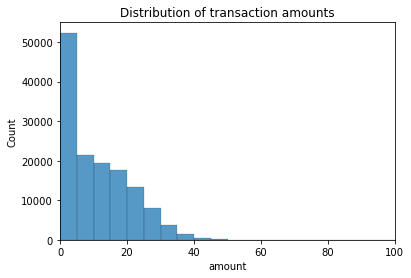

In [29]:
# Inspecting amount column
print('Number of transactions made: ', value_destructured.amount.notnull().sum(), end='\n\n')
print(value_destructured.amount.describe())

sns.histplot(x=value_destructured.amount, binwidth=5); # every $5
plt.title('Distribution of transaction amounts');
plt.xlim([0,100]); # removing outliers i.e. max value of $1062.28

In [30]:
# Transation value over $100 (hidden from the graph above)
print(f'#trans over $100: {(value_destructured.amount > 100).sum()}')
print(f'  in percentage: {(value_destructured.amount > 100).sum() / 138953 * 100:.2f}%')

#trans over $100: 478
  in percentage: 0.34%


Most of the amounts fall below $100 with some outliers that are minor enough to be ignored. Note that transaction values here includes those purchased with no offers as well.

Total number of rewards given: 306534


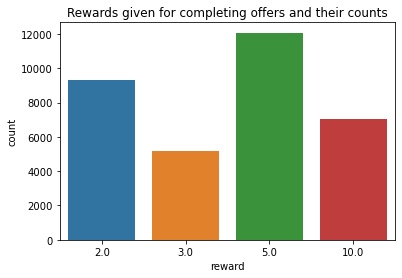

In [31]:
# Inspecting reward column
print('Total number of rewards given:', len(value_destructured.reward.notnull()))

sns.countplot(x=value_destructured.reward);
plt.title('Rewards given for completing offers and their counts');

Rewards are given for offers that are completed. Therefore, it must correspond to `offer completed` events only. Reward 5 has been given the most followed by reward 2. 

#### Commentary - `transcript` data:

There are four types of event following marketing funnels. As mentioned earlier an offer can be completed without receiving / viewing offer. Also, transaction can happen with no offer redeemed.

No missing data is found in `transcript` data. However, after destructuring `value` column many null values are generated, which is to address no transactions / rewards and delivers a correct picture - no need to drop.
 
For cleaning, 
- destructor dictionary in `value` column <font color="orangered">(to do)</font>
- make the keys of the ditionary in `value` column consistent <font color="orangered">(to do)</font>
- drop the original `value` column <font color="orangered">(to do)</font>

### Function to clean `transcript` data

In [32]:
def clean_transcript(df):
    ''' Clean the 'transcript' dataset, achieving :
    1. Destructure dictionary in 'value' column & create a new dataframe
    2. Ensure consistency by merging offer_id with offer id column
    3. Drop the duplicated offer id column
    3. Join the new dataframe to the original transcript dataframe
    4. Drop the original 'value' column

    INPUT: a Pandas dataframe that contains transcript data
    OUTPUT: a clean dataframe 
    '''
    
    # Instantiate df_clean as a copy of df
    df_clean = df.copy()
    
    # Destructoring dictionary in 'value' column 
    value_df = pd.json_normalize(df.value)
    
    # Making values in 'value_key' column consistent + testing the result
    # 'offer id' column merged 'offer_id' & test the change

    # For testing, the merged column size should match sum of count 1 & 2
    count1 = value_df['offer_id'].notnull().sum()
    count2 = value_df['offer id'].notnull().sum()
    
    value_df['offer_id'] = np.where(value_df['offer id'].notnull(), 
                                    value_df['offer id'], value_df['offer_id'])
    
    # Testing if merged successfully
    assert value_df['offer_id'].notnull().sum() == count1 + count2
    
    # Drop offer id column
    value_df = value_df.drop(columns='offer id')

    df_clean = df_clean.join(value_df)
    
    # Drop the original 'value' column
    df_clean = df_clean.drop(columns='value')
    
    
    return df_clean
    

In [33]:
# Returning the clean dataframe
transcript_v1 = clean_transcript(transcript)
transcript_v1.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Post cleaning inspection for `transcript_v1`
`transcript` is the core data that the other (profile, portfolio) dataframes are dependent on. We need to ensure that `transcript` is as clean, tidy as possible.

In [34]:
# If there is a value in 'amount', it should be about transaction
assert transcript_v1[transcript_v1.amount.notnull()].event.unique()[0] == 'transaction'

In [35]:
# Check for duplicates by 'person' and 'value_key'
transript_v1_duplicated = transcript_v1[transcript_v1.duplicated(keep=False)]
transript_v1_duplicated

,person,event,time,amount,offer_id,reward
66122,3dde94fa581145cb9f206624f1a94d5a,offer completed,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
66123,3dde94fa581145cb9f206624f1a94d5a,offer completed,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
66782,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
66783,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
67613,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,168,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
...,...,...,...,...,...,...
304756,0785f1fce0b04ba08e01c7d2ebab4917,offer completed,708,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
305550,b7e216b6472b46648272c29a52a86702,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
305551,b7e216b6472b46648272c29a52a86702,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0


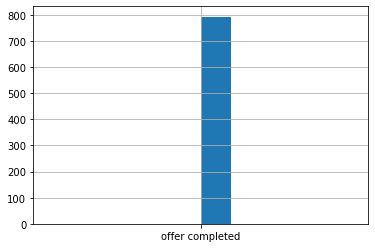

In [38]:
# Duplicated event 
transript_v1_duplicated.event.hist();

All the duplicated records are related to **offer completed** event. Let's inspect duplicated records with a sample.

In [40]:
# Inspection for duplicates with a sample 
sample = transcript_v1[transcript_v1.person == 'b7e216b6472b46648272c29a52a86702']
sample

,person,event,time,amount,offer_id,reward
1730,b7e216b6472b46648272c29a52a86702,offer received,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
18395,b7e216b6472b46648272c29a52a86702,offer viewed,12,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
48674,b7e216b6472b46648272c29a52a86702,transaction,138,26.84,NaN,NaN
48675,b7e216b6472b46648272c29a52a86702,offer completed,138,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
54929,b7e216b6472b46648272c29a52a86702,offer received,168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
69704,b7e216b6472b46648272c29a52a86702,offer viewed,174,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
93867,b7e216b6472b46648272c29a52a86702,transaction,246,33.44,NaN,NaN
93868,b7e216b6472b46648272c29a52a86702,offer completed,246,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
112546,b7e216b6472b46648272c29a52a86702,offer received,336,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
149137,b7e216b6472b46648272c29a52a86702,offer viewed,402,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN


#### Commentary:
About 397 fields (793 rows / 2) have duplicated records and it happends for `offer completed` event only. 

The above sample data shows exacity same records (idx# 305550, 305551). The duplicated fields do not really convey any meaningful data so drop duplicates (keep first).

### Drop duplicates in `transcript_v1`

In [41]:
print(f'Before dropping duplicates: {transcript_v1.shape[0]} records')
print(f'Total {transcript_v1.duplicated().sum()} duplicates exist')

Before dropping duplicates: 306534 records
Total 397 duplicates exist


In [42]:
transcript_v1 = transcript_v1.drop_duplicates(keep='first')

In [43]:
# Confirm the changes
assert transcript_v1.shape[0] == 306534 - 397, "There is something wrong"

In [44]:
# Save the clean data as transcript_v1
transcript_v1.to_csv('data/transcript_v1.csv', index=False)

## 2d. transcript_v1 - data transformation needed!
Before any explatory analysis, we need an extra handling of `transcript_v1` dataframe in order to clearly identify how funnels work and customers react to offers.

As instructed in the introdution, transactions can be made without customers actually viewing offers, which does not really tell that customers were influenced by the offers.

Therefore, we need to work on:
1. Make `event` column categorical ordered
2. Fill NaN value in `offer_id` for `transaction` made as a result of offer completion
3. Pivot `transcript_v1` to see which offer / person completed offer or not

The explanation here may not sound clear. So, I will explain the work along the way.

In [45]:
# Load the clean data
transcript_v1 = pd.read_csv('data/transcript_v1.csv')
portfolio_v1 = pd.read_csv('data/portfolio_v1.csv')

### Re-order event
It is understood that when an offer is completed, it follows funnles like below:  
    
    'offer received' -> 'offer viewed' ->'transaction' -> 'offer completed'

It is important to note that there are two offers that are informational. <font color="orangered">These two offers have only two events: offer received and offer viewed </font> for the offers to be completed.

In [46]:
# Get offer_id for the two information offer types
information_ids = portfolio_v1[portfolio_v1['offer_type'] == 'informational']['id'].to_list()
information_ids

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [47]:
# Events for informational offers
transcript_v1[transcript_v1['offer_id'].isin(information_ids)]['event'].unique()

array(['offer received', 'offer viewed'], dtype=object)

For the ease of analysis, we transform `event` column categorical, ordered following funnels.

In [48]:
# Transform event column into categorical ordered dtype
funnel_order = ['offer received', 'offer viewed', 'transaction', 'offer completed']
transcript_v1.event = pd.Categorical(transcript_v1.event, categories=funnel_order, ordered=True)

In [49]:
# Sorting the dataframe by person, offer_id and then event
# will represent dataframe in order of event(funnel) for each offer
transcript_sorted = transcript_v1.sort_values(by=['person', 'offer_id', 'time', 'event'],
                                              ascending=True)
transcript_sorted

,person,event,time,amount,offer_id,reward
247632,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
258632,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
113591,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139973,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
...,...,...,...,...,...,...
200113,ffff82501cea40309d5fdd7edcca4a07,transaction,498,13.17,NaN,NaN
214570,ffff82501cea40309d5fdd7edcca4a07,transaction,504,7.79,NaN,NaN
258113,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14.23,NaN,NaN
274495,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10.12,NaN,NaN


For later reference, create a function that facilitates the search of transaction details by a person's id.

In [50]:
def transaction_details(_id, df=transcript_v1):
    ''' To faciliate the search of transaction details of a customer.
    Firstly sorting 
    
    INPUT: 
        person_id: an id of a customer in the dataset
        df: default as the cleaned transcript (v1) dataframe.
    
    '''
    
    # Copy the input dataframe
    df_new = df.copy()
    
    # Transform event column into categorical ordered dtype
    funnel_order = ['offer received', 'offer viewed', 'transaction', 'offer completed']
    df_new.event = pd.Categorical(df_new.event, categories=funnel_order, ordered=True)
    
    # Get the data that corresponds to the input customer id
    df_ind = df_new[df_new.person == _id]
    
    return df_ind
    
    # Sorting the dataframe by offer_id, time and then event
    # will represent dataframe in order of event(funnel) for each offer
    df_ind = df_ind.sort_values(by=['offer_id', 'time', 'event'])

    return df_ind                               

In [51]:
transaction_details('ffff82501cea40309d5fdd7edcca4a07')

,person,event,time,amount,offer_id,reward
1393,ffff82501cea40309d5fdd7edcca4a07,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
15836,ffff82501cea40309d5fdd7edcca4a07,offer viewed,6,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
32762,ffff82501cea40309d5fdd7edcca4a07,transaction,60,16.06,NaN,NaN
32763,ffff82501cea40309d5fdd7edcca4a07,offer completed,60,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
37060,ffff82501cea40309d5fdd7edcca4a07,transaction,78,7.18,NaN,NaN
45575,ffff82501cea40309d5fdd7edcca4a07,transaction,120,9.12,NaN,NaN
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,168,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
69621,ffff82501cea40309d5fdd7edcca4a07,offer viewed,174,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
79660,ffff82501cea40309d5fdd7edcca4a07,transaction,198,22.88,NaN,NaN
79661,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0


#### Commentary:
The below method correctly sorts each offer by order of funnel. The rows with **transaction** does not contain offer_id. Therefore they need to be split and merged back after labeling complete offer. They can be merged on **time** of offer completed event which is exactly same as time of corresponding transaction.

### Splitting rows that contain `transaction` event

In [52]:
# Split rows with 'transaction' event
transaction_df = transcript_sorted[transcript_sorted.event == 'transaction']

# Remove transaction from transcript_sorted dataframe
transcript_sorted = transcript_sorted[transcript_sorted.event != 'transaction']

In [53]:
# Confirm the change
assert (transcript_sorted.event == 'transaction').sum() == 0, "There still is a row with transaction event."
assert (transcript_sorted.offer_id.isnull().sum()) == 0, "There is a missing record in offer_id column"

### Pivot transcript_sorted to label offer complete / incomplete
In order to make pivoting less complex, `reward` column (where event == `offer completed`) will be put aside. It will later be added after labeling.

In [73]:
# Subsetting reward (offer completed)
reward_df = transcript_v1[transcript_v1.event == 'offer completed']

In [55]:
# Remove reward column and subset transcript sorted dataframe
transcript_subset = transcript_sorted[['person', 'offer_id', 'time', 'event']]

# Pivot the subsetted dataframe 
# Group by and return the minimum time (the earliest) value 
offer_by_customer = transcript_subset.groupby(['person', 'offer_id', 'event']).min().unstack()
offer_by_customer.head()

time  \
event                                                             offer received   
person                           offer_id                                          
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7            NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2            NaN   
                                 2906b810c7d4411798c6938adc9daaa5          576.0   
                                 3f207df678b143eea3cee63160fa8bed          336.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0            NaN   

                                                                                \
event                                                             offer viewed   
person                           offer_id                                        
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7          NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2          NaN   
                                 2906b810c7d4411798c6938adc9daaa5          NaN   
                                 3f207df678b143eea3cee63160fa8bed        372.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0          NaN   

                                                                               \
event                                                             transaction   
person                           offer_id                                       
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7         NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2         NaN   
                                 2906b810c7d4411798c6938adc9daaa5         NaN   
                                 3f207df678b143eea3cee63160fa8bed         NaN   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0         NaN   

                                                                                   
event                                                             offer completed  
person                           offer_id                                          
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7             NaN  
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             NaN  
                                 2906b810c7d4411798c6938adc9daaa5           576.0  
                                 3f207df678b143eea3cee63160fa8bed             NaN  
                                 4d5c57ea9a6940dd891ad53e9dbe8da0             NaN

#### Commentary:
The pivoted dataframe `is_offer_complete` contains multi-layered index and column. It contains all 10 offer types (represented by `offer_id`) per each person. 

When it comes to column, `time` and `event` features are multi-layered, which will need a further processing in the following section.

In [56]:
# Inspect if all persons have 10 offers using progress bar

member_ids = transcript_subset.person

for _id in tqdm(member_ids):
    assert offer_by_customer.loc[_id].shape[0] == 10

100%|██████████| 167184/167184 [01:18<00:00, 2122.27it/s]


Yes indeed! This will allow us to check which offer has actually been sent and which hasn't

### Reset multi-index and drop 'transaction' column
The multi-index column can be reset. Also `transaction` is regenerated as it is part of the categorical `event` column. To faciliate the labeling, we can drop it. Also, 

In [57]:
# Resetting multi-index column
offer_by_customer.columns = offer_by_customer.columns.droplevel(0)

In [58]:
# Check if transaction column has any non-null value
assert offer_by_customer['transaction'].notnull().sum() == 0, 'There is a non-null value in transaction column'

# Drop the transaction column
offer_by_customer = offer_by_customer.drop(columns='transaction')

In [59]:
offer_by_customer

event                                                              offer received  \
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7             NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             NaN   
                                 2906b810c7d4411798c6938adc9daaa5           576.0   
                                 3f207df678b143eea3cee63160fa8bed           336.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0             NaN   
...                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837             NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9           504.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd             NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d             NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4             0.0   

event                                                              offer viewed  \
person                           offer_id                                         
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2           NaN   
                                 2906b810c7d4411798c6938adc9daaa5           NaN   
                                 3f207df678b143eea3cee63160fa8bed         372.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0           NaN   
...                                                                         ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837           NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         534.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd           NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d           NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4           6.0   

event                                                              offer completed  
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7              NaN  
                                 2298d6c36e964ae4a3e7e9706d1fb8c2              NaN  
                                 2906b810c7d4411798c6938adc9daaa5            576.0  
                                 3f207df678b143eea3cee63160fa8bed              NaN  
                                 4d5c57ea9a6940dd891ad53e9dbe8da0              NaN  
...                                                                            ...  
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837              NaN  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9            504.0  
                                 ae264e3637204a6fb9bb56bc8210ddfd              NaN  
                                 f19421c1d4aa40978ebb69ca19b0e20d              NaN  
                                 fafdcd668e3743c1bb461111dcafc2a4             60.0  

[169940 rows x 3 columns]

### Labeling completed / incompleted offer
Now we have **offer received**, **offer viewed** and **offer completed** column following funnel. We label **`completed`** when all three columns are filled with non-null values. 

**Labeling matrix for possible mix (o: non-null value, x: null):**

| offer received | offer viewed | offer completed | label |
| --- | --- | --- | --- |
| o | o | o | completed |
| o | o | x | incomplete |
| o | x | o | incomplete |
| o | x | x | incomplete |
| x | x | x | unsent |

As inspected earlier, the dataframe contains data for offers that have not been sent to a person and we denote that as **`unsent`** for any future use.

In [60]:
def label_offer_by_customer(df=offer_by_customer):
    ''' Create a new dataframe that contains label column
    to represent the status of offer. The column will contain
    three labels that are 'completed', 'incomplete', 'no offer'
    
        'completed': customers has been influenced by offer when
            purchasing a product
        'incomplete': customers may have purchased a product or not
            which however was not influenced by offer
        'unsent': a particular offer has not been sent by Starbucks            
    
    INPUT: a pivoted dataframe that contains funnel information by
        customer(person) and offer(offer_id)
        
    OUTPUT: a dataframe that has either of the three labels attached    
    '''
    
    # Instantiate a copy of dataframe
    df_new = offer_by_customer.copy()

    # Change dtype categorical --> str
    # otherwise, a new column cannot be added
    df_new.columns = df_new.columns.astype(str)

    # Instantiate a new 'offer_status' column
    df_new['offer_status'] = ''
    
    for idx, rows in tqdm(df_new.iterrows(), total=df_new.shape[0]):
    
        # Set conditions to check if there is non-null value
        is_received = not math.isnan(rows['offer received'])
        is_viewed = not math.isnan(rows['offer viewed'])
        is_completed = not math.isnan(rows['offer completed'])

        # Label as per the logic spcified in the labeling matrix 
        if is_received and is_viewed and is_completed:
            df_new.loc[idx, 'offer_status'] = 'completed'

        elif is_received and is_viewed and not is_completed:
            df_new.loc[idx, 'offer_status'] = 'incomplete'

        elif is_received and not is_viewed and is_completed:
            df_new.loc[idx, 'offer_status'] = 'incomplete'

        elif is_received and not is_viewed and not is_completed:
            df_new.loc[idx, 'offer_status'] = 'incomplete'

        elif not is_received and not is_completed and not is_viewed:
            df_new.loc[idx, 'offer_status'] = 'unsent'

        else:
            df_new.loc[idx, 'offer_status'] = np.nan

    return df_new

In [61]:
offer_by_customer_labeled = label_offer_by_customer(df=offer_by_customer)

100%|██████████| 169940/169940 [05:19<00:00, 532.21it/s]


In [62]:
# Check if offer_status has null values
assert offer_by_customer_labeled.offer_status.isnull().sum() == 0, 'There is a null value'

In [63]:
# Visually check with 10 samples 
offer_by_customer_labeled.sample(10) # ok!

,event,offer received,offer viewed,offer completed,offer_status
person,offer_id,,,,
2fc2ef210bdd44b1bbebf4f5e809c871,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,36.0,90.0,completed
6e2848db7c654376ad1da5616bba5395,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,unsent
0ab26a89e3494acd922ea9fd0ff938e5,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,unsent
dad8efdccb7e47ee8e628db1b61c847c,3f207df678b143eea3cee63160fa8bed,168.0,168.0,NaN,incomplete
0cc67e089ff64108a2fa117971f666f9,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,6.0,NaN,incomplete
8ec6ce2a7e7949b1bf142def7d0e0586,3f207df678b143eea3cee63160fa8bed,336.0,366.0,NaN,incomplete
a400237df33c4cb7a103a91607f6379b,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,unsent
74352900d7464cc1a6385b226c10e6b1,ae264e3637204a6fb9bb56bc8210ddfd,504.0,510.0,NaN,incomplete
541c158d0fb041f69c9d457c0ca25ef2,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,unsent


### Merging subsetted data 
Now we merge the earlier subsetted **amount** & **reward** information for the ease pivoting operations. They are saved in `transaction_df` & `reward_df` respectively. 

`transaction_df` does not have **offer_id** so we merge based on the time that offers were completed. Also, offer_id, reward columns do not have any values other than NaN, and also event column is not unnecessary (it only has transaction as value) so drop them before the merge.

In [64]:
# Instantiate dataframe to be merged
df_merged = offer_by_customer_labeled.copy()

# Reset index for merge 
df_merged = df_merged.reset_index()

In [66]:
# Prepare transaction dataframe
transaction_df = transaction_df.drop(columns=['event', 'offer_id', 'reward'])

# Merge the dataframes
df_merged = pd.merge(df_merged, transaction_df, how='left',
                     left_on=['person', 'offer completed'], right_on=['person', 'time'])

In [67]:
# Check if any record has been removed/added after the merge
assert df_merged.shape[0] == 169940, "There is a record lost/added from the merge"
assert df_merged[df_merged['offer completed'] != df_merged['time']]['offer completed'].sum() == 0

# Then drop duplicated column due to difference in column name
df_merged = df_merged.drop(columns='time')

In [68]:
# Inspect the result
df_merged.head()

,person,offer_id,offer received,offer viewed,offer completed,offer_status,amount
0,0009655768c64bdeb2e877511632db8f,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,unsent,NaN
1,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,unsent,NaN
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,incomplete,10.27
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,incomplete,NaN
4,0009655768c64bdeb2e877511632db8f,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,unsent,NaN


There is no record lost or added after the merge which is good. However, note that the third row has a suspicious record where `offer_status` is incomplete but there still is an amount. Let's investigate them.

In [69]:
df_merged[(df_merged['offer_status'] == 'incomplete') & (df_merged['amount'].notnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4536 entries, 2 to 169906
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           4536 non-null   object 
 1   offer_id         4536 non-null   object 
 2   offer received   4536 non-null   float64
 3   offer viewed     0 non-null      float64
 4   offer completed  4536 non-null   float64
 5   offer_status     4536 non-null   object 
 6   amount           4536 non-null   float64
dtypes: float64(4), object(3)
memory usage: 283.5+ KB


It is very clear that transaction amount was added to incomplete offer when a customer actually made a transaction without viewing offer (so not influenced by the offer). 

No action yet to take and moving on with merging `reward_df` for now. `reward_df` has unncessary columns: thare are `event` (only offer completed has reward) and `amount` (no value) to drop.

In [70]:
# Inspecting reward_df 
reward_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33182 entries, 12658 to 306130
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   person    33182 non-null  object  
 1   event     33182 non-null  category
 2   time      33182 non-null  int64   
 3   amount    0 non-null      float64 
 4   offer_id  33182 non-null  object  
 5   reward    33182 non-null  float64 
dtypes: category(1), float64(2), int64(1), object(2)
memory usage: 1.6+ MB


In [74]:
# Prepare reward dataframe
# Drop unncessary columns
reward_df = reward_df.drop(columns=['event', 'amount'])

# Merge with reward_df 
df_merged = pd.merge(df_merged, reward_df, how='left', 
                     left_on=['person', 'offer_id', 'offer completed'], 
                     right_on=['person', 'offer_id', 'time'])

In [75]:
# Check for any added/removed records after the merge
assert df_merged.shape[0] == 169940, "There is a record lost/added from the merge"

# Then, drop duplicated column due to difference in column name
df_merged = df_merged.drop(columns='time')

In [76]:
df_merged

,person,offer_id,offer received,offer viewed,offer completed,offer_status,amount,reward
0,0009655768c64bdeb2e877511632db8f,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,unsent,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,unsent,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,incomplete,10.27,2.0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,incomplete,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,unsent,NaN,NaN
...,...,...,...,...,...,...,...,...
169935,ffff82501cea40309d5fdd7edcca4a07,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,unsent,NaN,NaN
169936,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,534.0,504.0,completed,7.79,5.0
169937,ffff82501cea40309d5fdd7edcca4a07,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,unsent,NaN,NaN
169938,ffff82501cea40309d5fdd7edcca4a07,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,unsent,NaN,NaN


<font color="orangered">Warning</font> Row 169936 has a suspicous record where offer completed time is earlier than offer viewed time. Let's investigate.

In [78]:
# Using the custom function defined earlier
inspect = transaction_details('ffff82501cea40309d5fdd7edcca4a07')
inspect[inspect.time > 500][:5]

,person,event,time,amount,offer_id,reward
202817,ffff82501cea40309d5fdd7edcca4a07,offer received,504,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
214570,ffff82501cea40309d5fdd7edcca4a07,transaction,504,7.79,NaN,NaN
214571,ffff82501cea40309d5fdd7edcca4a07,offer completed,504,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
230484,ffff82501cea40309d5fdd7edcca4a07,offer viewed,534,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
246248,ffff82501cea40309d5fdd7edcca4a07,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,NaN


### `LABELING ADJUSTMENT` Incorrect labeling

It is noticeable that the customer viewed an offer after offer completed, and then the customer was not influenced by the offer and the offer is not considered complete.

And the previous groupby operations assumed the dataframe was ordered by funnel but created a wide form pivot table with the minimum time (earliest record) so couldn't catch this exceptional case. 

There are over 3708 records that are incorrectly labeled, which need an additional adjustment.

In [79]:
df_merged[df_merged['offer viewed'] > df_merged['offer completed']]

,person,offer_id,offer received,offer viewed,offer completed,offer_status,amount,reward
8,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,completed,8.57,5.0
9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,completed,14.11,2.0
101,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576.0,654.0,576.0,completed,29.77,3.0
130,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168.0,228.0,210.0,completed,28.73,5.0
132,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,504.0,564.0,534.0,completed,21.35,2.0
...,...,...,...,...,...,...,...,...
169887,fff29fb549084123bd046dbc5ceb4faa,ae264e3637204a6fb9bb56bc8210ddfd,0.0,642.0,168.0,completed,15.16,10.0
169888,fff29fb549084123bd046dbc5ceb4faa,f19421c1d4aa40978ebb69ca19b0e20d,408.0,438.0,426.0,completed,24.56,5.0
169896,fff3ba4757bd42088c044ca26d73817a,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,210.0,168.0,completed,22.76,5.0
169926,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,576.0,666.0,588.0,completed,10.98,5.0


In [80]:
# Adjusting the incorrect labeling
df_merged.loc[df_merged['offer viewed'] > df_merged['offer completed'], 'offer_status'] = 'incomplete'

# Test the change
assert (df_merged.loc[df_merged['offer viewed'] > df_merged['offer completed'], 'offer_status'] != 'incomplete').sum()  == 0, "The adjustment failed..."

### `LABELING ADJUSTMENT` Informational offer type
In the beginning, we figured that there are two information offers and they only have two possible events: offer received and offer viewed. Therefore, we consider it completed when the two events are made.

In [81]:
information_ids

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [82]:
# Copy df_merged dataframe
temp = df_merged.copy()

# Save all records with information offers and those not
temp_informational = df_merged.loc[df_merged['offer_id'].isin(information_ids)]
temp_transactional = df_merged.loc[~df_merged['offer_id'].isin(information_ids)]

# Check if subsetting is done correctly
assert temp_informational.shape[0] + temp_transactional.shape[0] == temp.shape[0], "Wrong subsetting"

In [83]:
# Slicing data from temp_informational
# that have values in offer received and offer viewed columns
cond_received = temp_informational['offer received'].notnull()
cond_viewed = temp_informational['offer viewed'].notnull()

# Adjusting the incorrect labeling
temp_informational.loc[cond_viewed & cond_viewed, 'offer_status'] = 'completed'

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [88]:
# Check if changed correctly
assert (temp_informational.loc[cond_viewed & cond_viewed]['offer_status'] == 'incomplete').sum() == 0, "Failed adjustment"

# Saving the change into the dataframe
df_merged_adj = pd.concat([temp_informational, temp_transactional])

# If changed correctly save the dataframe
df_merged_adj.to_csv('data/transcript_labeled.csv', index=True)

---
<a id="explore-part1"></a>
# `SECTION 3` Exploratory analysis : Part1

Here we explore the individual dataset first. In the next section (Part2) we will continue the analysis with merged datasets. 

In [89]:
# Load the clean dataset
portfolio_v1 = pd.read_csv('data/portfolio_v1.csv')
profile_v1 = pd.read_csv('data/profile_v1.csv', parse_dates=True)
transcript_labeled = pd.read_csv('data/transcript_labeled.csv')

del transcript_labeled['Unnamed: 0']

In [90]:
portfolio_v1.head()

,reward,difficulty,duration,offer_type,id,mobile,social,email,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,1


## 3a. Offer types

In [91]:
portfolio_v1.groupby('offer_type').mean()

,reward,difficulty,duration,mobile,social,email,web
offer_type,,,,,,,
bogo,7.5,7.50,6.0,1.00,0.75,1.0,0.75
discount,3.0,11.75,8.5,0.75,0.50,1.0,1.00
informational,0.0,0.00,3.5,1.00,0.50,1.0,0.50


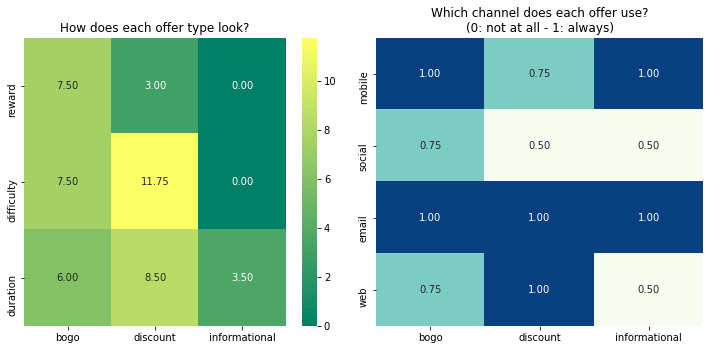

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

sns.heatmap(portfolio_v1.iloc[:, :5].groupby('offer_type').mean().T, 
            annot=True, fmt='.2f', cmap='summer', ax=ax1);
sns.heatmap(portfolio_v1.iloc[:, 3:].groupby('offer_type').mean().T, 
            annot=True, fmt='.2f', cmap='GnBu', cbar=False, ax=ax2);

ax1.set(title ='How does each offer type look?', xlabel='', ylabel='');
ax2.set(title ='Which channel does each offer use?\n(0: not at all - 1: always)',
        xlabel='', ylabel='')

plt.tight_layout(pad=1.2)

# Save figure
plt.savefig('images/offer_type.png')
plt.show()

`discount` offer requires the highest minimum spends to get but has the longest duration, assuming customers feel the influence longer that the others. Regardless of offer type, `email` is always used when communicating the offer. `bogo` offer uses the widest number of channels. 

The analysis will be more meaningful when offer type is explored together with customer profile and transction data, which will be done later after mering the dataset.

## 3b.  Demographics

In [99]:
profile_v1.shape[0] # total 14825 unique demographic data

14825

In [100]:
profile_v1.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [101]:
# It looks that 'became_member_on' is still object... 
# Convert to datetime object
profile_v1['became_member_on'] = pd.to_datetime(profile_v1['became_member_on'])

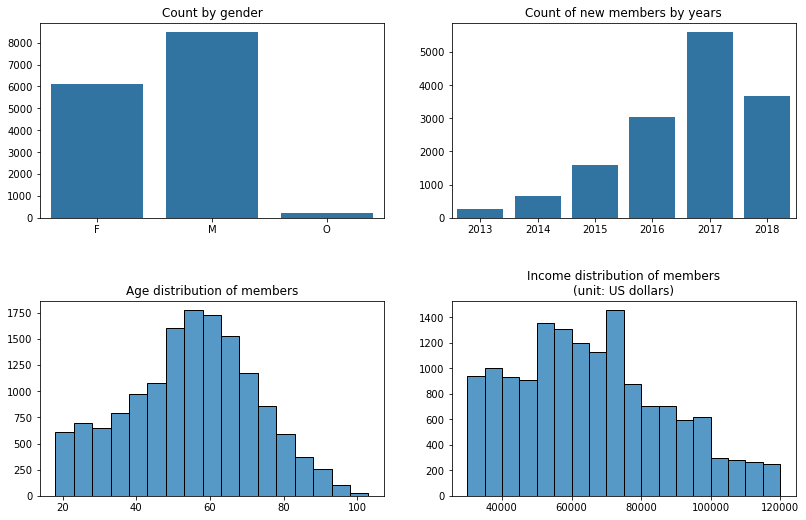

In [102]:
base_color = sns.color_palette()[0]

fig, axes = plt.subplots(2, 2, figsize=(12,8))

fig1 = sns.countplot(x=profile_v1.gender, ax=axes[0,0], color=base_color)
fig2 = sns.countplot(x=profile_v1.became_member_on.dt.year, ax=axes[0,1], color=base_color)
fig3 = sns.histplot(x=profile_v1.age, binwidth=5, ax=axes[1,0])
fig4 = sns.histplot(x=profile_v1.income, binwidth=5000, ax=axes[1,1])

fig1.set(title='Count by gender', xlabel='', ylabel='')
fig2.set(title='Count of new members by years', xlabel='', ylabel='')
fig3.set(title='Age distribution of members', xlabel='', ylabel='')
fig4.set(title='Income distribution of members\n(unit: US dollars)', xlabel='', ylabel='')

plt.tight_layout(pad=3.5)
plt.show()

In [103]:
# Percentage of male, female and others
profile_v1.gender.value_counts() / profile_v1.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [104]:
# Summary statistics for age
profile_v1.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [105]:
# Summary statistics for income
profile_v1.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

**Gender:** based on this dataset, male customers accounts for 57% of total, more than female (or others). 

**Date:** The growth of new members has increased over time, but it may need better comparison against other metrics like the total visitor volume to validate the organic growth. Also, the data collection period is not clear so 2013 and 2018 data may be biased. 

**Age:** The minimum age is 18 which may be due to age restriction for members. With the median of 55, 50% of the members fall into interquartile range is between 42 and 66. There are some members above 100, which may be true or caused by survey error.

**Income:** Median income is $64,000. The distribution is skewed to the right which seems natural for income distribution.

## 3c. Offer completion
Using the cleaned, pivoted dataframe saved in `transcript_labeled.csv`

In [109]:
print('Number of unique customers: ', transcript_labeled.person.nunique())
print('Number of unique offer types: ', transcript_labeled.offer_id.nunique())

Number of unique customers:  16994
Number of unique offer types:  10


In [110]:
# Total records
transcript_labeled.shape[0]

169940

The number of total record is 169940, which I interpret as the total mix of possible transactions. 

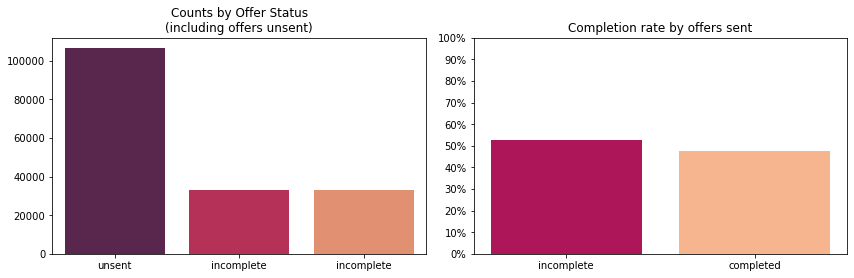

In [112]:
# Set color for the plots
color_rocket = list(sns.color_palette('rocket'))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

fig1_order = ['unsent', 'incomplete', 'incomplete']
fig1 = sns.countplot(x=transcript_labeled.offer_status, ax=ax1, order=fig1_order, palette="rocket");

# Proportion of offer completion over total sent
offer_sent = transcript_labeled[transcript_labeled.offer_status != 'unsent'].offer_status.value_counts()
fig2 = plt.bar(x=offer_sent.index, height=offer_sent.values / offer_sent.values.sum(),
               color=[color_rocket[2], color_rocket[-1]]);

ax1.set(title='Counts by Offer Status\n(including offers unsent)', ylabel='', xlabel='');
ax2.set(title='Completion rate by offers sent', ylabel='', xlabel='');
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

# Save figure
plt.tight_layout(pad=1.2)
plt.savefig('images/offer_status.png')
plt.show()

In [113]:
transcript_labeled['offer_status'].value_counts() / transcript_labeled.shape[0]

unsent        0.627586
incomplete    0.195522
completed     0.176892
Name: offer_status, dtype: float64

In [114]:
offer_sent / offer_sent.sum()

incomplete    0.525013
completed     0.474987
Name: offer_status, dtype: float64

#### Commentary:

16,994 unique customers and 10 unique offers are represented in this dataset, which gives 169,940 total mix of possible offers. Around 63% offers are `unsent`, most likely because it was identified that offers do not fulfill the needs of specific customers or the opportunity was misinterpreted and therefore missed, which is the gap that we need to fill in this analysis. 

When considering those offers that were actually sent, about 52% turned out incomplete, which means offers did not influenced customers to purchase.

# informational offers: 33988
# transactional offers: 135952


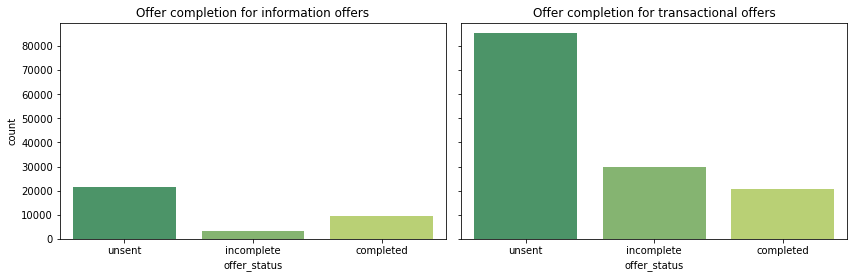

In [124]:
# Get subset data for informational and transactional offers
informational_ids = portfolio_v1.loc[portfolio_v1['offer_type'] == 'informational', 'id'].to_list()

transcript_infos = transcript_labeled[transcript_labeled['offer_id'].isin(informational_ids)]
transcript_trans = transcript_labeled[~transcript_labeled['offer_id'].isin(informational_ids)]

print('# informational offers:', len(transcript_infos))
print('# transactional offers:', len(transcript_trans))

# Visualization
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True)

# Set order for plots
status_order = ['unsent', 'incomplete', 'completed']

fig1 = sns.countplot(x=transcript_infos.offer_status, ax=ax1, order=status_order, palette="summer");
fig2 = sns.countplot(x=transcript_trans.offer_status, ax=ax2, order=status_order, palette="summer");

ax1.set_title('Offer completion for information offers');
ax2.set_title('Offer completion for transactional offers');
ax2.set(ylabel='')

plt.tight_layout(pad=1.2)

# Save figure
plt.savefig('images/completion_by_offer.png')
plt.show()

Around 20% of the total dataset are informational and the rest 80% are transactional. In the split data, it is clear that informational offers have higher completion rate.

### Purchased but incomplete offers
Earlier it was identified that there are some offers incorrectly marked completed without customers actually viewing them. From the business perspective, this group of customers are not influenced by offers when purchasing products, it may not be a good idea to send offers. 

In [125]:
# Creating some conditions
cond_purchased = transcript_labeled.amount.notnull()
cond_incomplete = transcript_labeled.offer_status == 'incomplete'
cond_viewed = transcript_labeled['offer viewed'].notnull()

print(f'# offer incomplete (total): {transcript_labeled[cond_incomplete].shape[0]}')
print(f'# offer incomplete but purchased: {transcript_labeled[cond_incomplete & cond_purchased].shape[0]}')
print(f'# offer incomplete and viewed after purchase: {transcript_labeled[cond_incomplete & cond_purchased & cond_viewed].shape[0]}')

# offer incomplete (total): 33227
# offer incomplete but purchased: 8244
# offer incomplete and viewed after purchase: 3708


### Purchase amounts

In [126]:
transcript_labeled.amount.describe()

count    28996.000000
mean        20.388305
std         39.952649
min          0.150000
25%         10.817500
50%         16.610000
75%         23.390000
max       1015.730000
Name: amount, dtype: float64

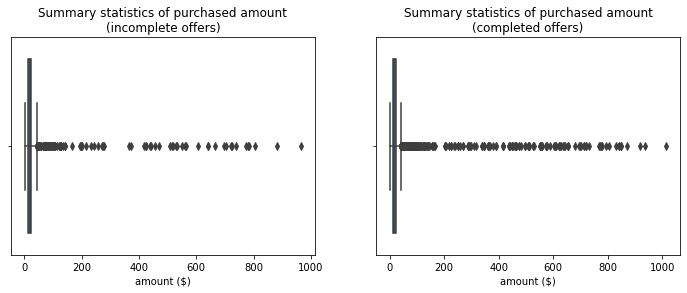

In [127]:
# Two box plot graphs 
# fig1: incomplete but putchased, fig2: completed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig1 = sns.boxplot(x=transcript_labeled[cond_incomplete].amount, ax=ax1);
fig2 = sns.boxplot(x=transcript_labeled[~cond_incomplete].amount, ax=ax2);

ax1.set(title='Summary statistics of purchased amount\n(incomplete offers)', xlabel='amount ($)', ylabel='')
ax2.set(title='Summary statistics of purchased amount\n(completed offers)', xlabel='amount ($)', ylabel='')

plt.show()

Purchase amount varies from 15 cents to 1015 dollars, while 75% fall below 23.39 dollars per receipt. Now let's see visualizations after removing outliers. Outliers here are difined as observations that are outside 1.5 x interquantile range below Q1 and above Q3.

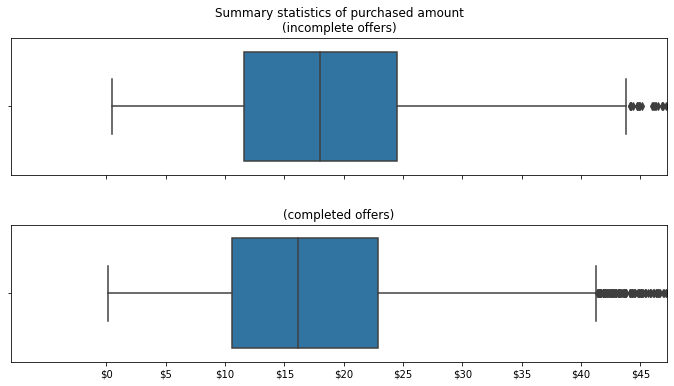

In [128]:
# Prepare for statistics
Q1_purchased = transcript_labeled.amount.describe()['25%']
Q3_purchased = transcript_labeled.amount.describe()['75%']
IQR_purchased = Q3_purchased - Q1_purchased
outlier_lower = Q1_purchased - 1.5 * IQR_purchased
outlier_upper = Q3_purchased + 1.5 * IQR_purchased

# Two box plot graphs 
# fig1: incomplete but putchased, fig2: completed

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
fig1 = sns.boxplot(x=transcript_labeled[cond_incomplete].amount, ax=ax1);
fig2 = sns.boxplot(x=transcript_labeled[~cond_incomplete].amount, ax=ax2);

ax1.set(title='Summary statistics of purchased amount\n(incomplete offers)',xlabel='', ylabel='')
ax2.set(title='(completed offers)', xlabel='', ylabel='')

ax1.set_xticks(np.arange(0, 100, 5))
ax1.set_xticklabels([f'${str(n)}' for n in np.arange(0, 100, 5)])
ax1.set_xlim(outlier_lower, outlier_upper+5)

plt.tight_layout(pad=3)

plt.show()

Those customers who purchased products without viewing offers have slightly higher spends when compared with those purchases influenced by others. It is self-explanatory as completed offers should have some discounts applied to them. 

<a id="explore-part2"></a>
# `Section4` Exploratory analysis - Part2
|
In this section, we would like to go deeper into offer completion by offer type and demographics. In order to do this, we will merge the datasets. `unsent` offer status does not clearly show if customers completed offers or not, so we will subset those offers that customers actually received only **(so excluding unsent)**.

## 4a. Completion by offer type

### Prepare dataset with function

In [5]:
# Load the clean dataset
portfolio_v1 = pd.read_csv('data/portfolio_v1.csv', parse_dates=True)
transcript_labeled = pd.read_csv('data/transcript_labeled.csv')
del transcript_labeled['Unnamed: 0']


# Create a function to prepare dataset for analysis
def prepare_completion_by_offer(df1=transcript_labeled, df2=portfolio_v1):
    ''' Function to prepare a dataframe ready for the analysis
    of offer completion by offer type.
    
    INPUT (set by default): 
        df1: the transcript_labeled dataset 
        df2: the cleaned portfolio_v1 dataset
        
    OUTPUT: a new merged dataframe 
    
    '''
    
    # Get all records that were sent (excluding unsent)
    offer_sent = df1[df1['offer_status'] != 'unsent']
    
    # Create a dataframe that shows
    # number of completed and incomplete offers by offer id
    completion_by_offer = offer_sent.groupby(['offer_id', 'offer_status']).size().unstack()
    
    # Compute completion rate
    completion_by_offer['completion_rate'] = completion_by_offer['completed'] / completion_by_offer.sum(axis=1).values
    completion_by_offer['incompletion_rate'] = completion_by_offer['incomplete'] / completion_by_offer.sum(axis=1).values
    
    # Sort by completed rate
    completion_by_offer.sort_values('completion_rate', ascending=False, inplace=True)
    
    # Merge the data sets
    completion_by_offer_merged = pd.merge(completion_by_offer.reset_index(), df2, 
                                          left_on='offer_id', right_on='id', how='left')
    
    # Drop duplicated id column
    completion_by_offer_merged.drop(columns='id', inplace=True)
    
    # Print the merged dataset
    return completion_by_offer_merged

In [6]:
# Get the prepared dataset
completion_by_offer = prepare_completion_by_offer()
completion_by_offer.head()

,offer_id,completed,incomplete,completion_rate,incompletion_rate,reward,difficulty,duration,offer_type,mobile,social,email,web
0,5a8bc65990b245e5a138643cd4eb9837,5674,646,0.897785,0.102201,0,0,3,informational,1,1,1,0
1,fafdcd668e3743c1bb461111dcafc2a4,4033,2299,0.636924,0.363040,2,10,10,discount,1,1,1,1
2,2298d6c36e964ae4a3e7e9706d1fb8c2,3820,2505,0.603953,0.396010,3,7,7,discount,1,1,1,1
3,3f207df678b143eea3cee63160fa8bed,3635,2696,0.574159,0.425802,0,0,4,informational,1,0,1,1
4,f19421c1d4aa40978ebb69ca19b0e20d,3129,3133,0.499681,0.500279,5,5,5,bogo,1,1,1,1


In [9]:
# Get more intuitive offer names with mix of values

def get_offer_name(df, cols):
    ''' Concatenate cell data from a dataframe to formulate a unique offer name
    For example, if input cols are 'offer_type', 'reward', 'difficulty', 'duration'
    and respective values are 'discount', 2, 10, 10, returning name will be disc021010
    
    INPUT: 
        df: a dataframe that contains information for offer names 
            i.e. 'offer_type', 'reward', 'difficulty', 'duration'
        cols: columns that values will be extracted from
        
    OUTPUT: 
        a list of unique offer name
    
    '''
    
    # Get the subset of data needed
    df_subset = df[cols]
    
    # Instantiate a list of offer names
    offer_names = list()
    
    # Iterate by row
    for idx, values in df_subset.iterrows():
        
        # Instantiate name
        name = ''
        
        for item in values:
            # If item is string, get the first 4 letters
            if type(item) == str:
                item = item[:4]
            
            # If item is integer, check if the value < 10, 
            # then add '0' in front and transform it to string
            if type(item) == int and item < 10:
                item = '0' + str(item)
            else:
                item = str(item)
            
            # Concatenate item 
            name += item
        
        # Add completed name to a list of offer names
        offer_names.append(name)
        
        
    return offer_names

In [10]:
# Add the offer names to the dataframe and set it as an index
col_names = ['offer_type', 'reward', 'difficulty', 'duration']
completion_by_offer['offer_name'] = get_offer_name(completion_by_offer, col_names)
completion_by_offer.set_index('offer_name', inplace=True)

In [11]:
completion_by_offer # good!

,offer_id,completed,incomplete,completion_rate,incompletion_rate,reward,difficulty,duration,offer_type,mobile,social,email,web
offer_name,,,,,,,,,,,,,
info000003,5a8bc65990b245e5a138643cd4eb9837,5674,646,0.897785,0.102201,0,0,3,informational,1,1,1,0
disc021010,fafdcd668e3743c1bb461111dcafc2a4,4033,2299,0.636924,0.363040,2,10,10,discount,1,1,1,1
disc030707,2298d6c36e964ae4a3e7e9706d1fb8c2,3820,2505,0.603953,0.396010,3,7,7,discount,1,1,1,1
info000004,3f207df678b143eea3cee63160fa8bed,3635,2696,0.574159,0.425802,0,0,4,informational,1,0,1,1
bogo050505,f19421c1d4aa40978ebb69ca19b0e20d,3129,3133,0.499681,0.500279,5,5,5,bogo,1,1,1,1
bogo101005,4d5c57ea9a6940dd891ad53e9dbe8da0,2436,3894,0.384834,0.615128,10,10,5,bogo,1,1,1,1
bogo101007,ae264e3637204a6fb9bb56bc8210ddfd,2314,4060,0.363037,0.636926,10,10,7,bogo,1,1,1,0
bogo050507,9b98b8c7a33c4b65b9aebfe6a799e6d9,1922,4433,0.302439,0.697528,5,5,7,bogo,1,0,1,1
disc021007,2906b810c7d4411798c6938adc9daaa5,1891,4394,0.300875,0.699091,2,10,7,discount,1,0,1,1


### Visualization 

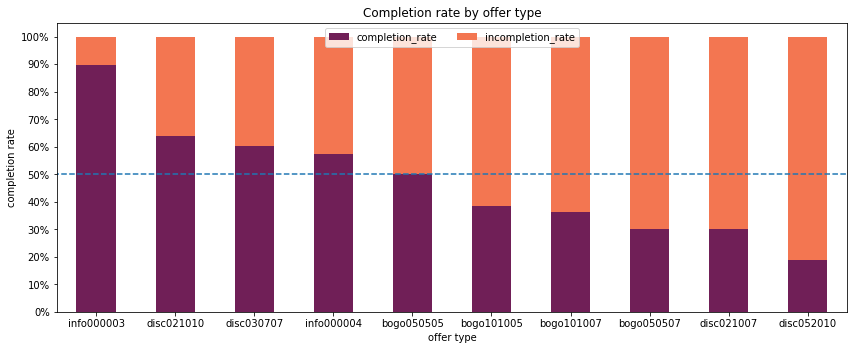

In [141]:
fig_color = [color_rocket[1], color_rocket[-2]]
completion_by_offer[['completion_rate', 'incompletion_rate']].plot(kind='bar', stacked=True, figsize=(12,5), color=fig_color);

plt.title('Completion rate by offer type')
plt.xlabel('offer type')
plt.ylabel('completion rate')
plt.xticks(rotation=0)
plt.yticks(ticks=np.arange(0, 1+0.1, 0.1), labels=['{:.0f}%'.format(n*100) for n in np.arange(0, 1+0.1, 0.1)])
plt.legend(loc='upper center', ncol=4)
plt.hlines(0.5, xmin=-10, xmax=100, linestyles='--', colors=sns.color_palette()[0])

# Save figure
plt.tight_layout(pad=1.2)
plt.savefig('images/completion_by_offer_granular.png')
plt.show()

Note that there are two offers that are informational and they have completion rate of 0%, which originally had only two events: offer received and offer viewed. 

Commentary to follow with the visualization of each offer category.

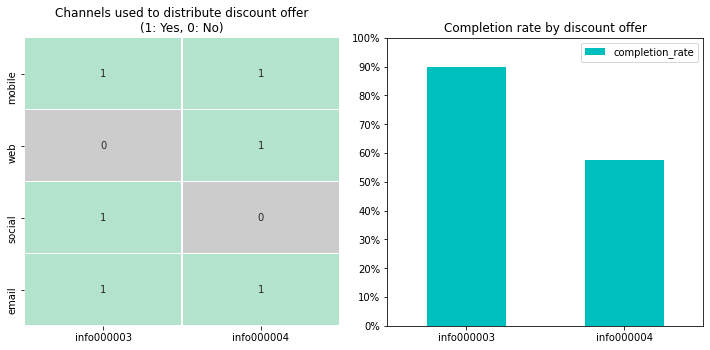

In [146]:
# Set color for plotting
pastel_color = sns.color_palette('Pastel1')

# Subset discount offers
completion_by_infos = completion_by_offer.iloc[completion_by_offer.index.str.contains('info')].reset_index()
channels = ['mobile', 'web', 'social', 'email']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Figure1 - heatmap for binary
discounts_by_offer = completion_by_infos.set_index('offer_name')[channels]
sns.heatmap(discounts_by_offer.T, linewidths = 0.30, annot = True, 
            cmap='Pastel2_r', cbar=False, ax=ax1);

# Labels
ax1.set_title('Channels used to distribute discount offer\n(1: Yes, 0: No)')
ax1.set(xlabel='', ylabel='')

# Figure2 - bar
completion_by_infos[['offer_name', 'completion_rate']].plot(kind='bar', ax=ax2, color='coolrwarm')

# Labels
ax2.set(title='Completion rate by discount offer')
ax2.set_xticks(ticks=np.arange(len(completion_by_infos)))
ax2.set_xticklabels(labels=completion_by_infos['offer_name'], rotation=0)
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

plt.tight_layout(pad=1.2)

# Save figure
plt.savefig('images/channels_by_info.png')
plt.show()

Informational offers have generally higher completion rate. Depsite slightly longer duration, completion rate of `info000003` is a lot higher than that of `info000004`. The difference possibly comes from type of distribution channel: `info000003` used social whereas `info info000004` used web. 

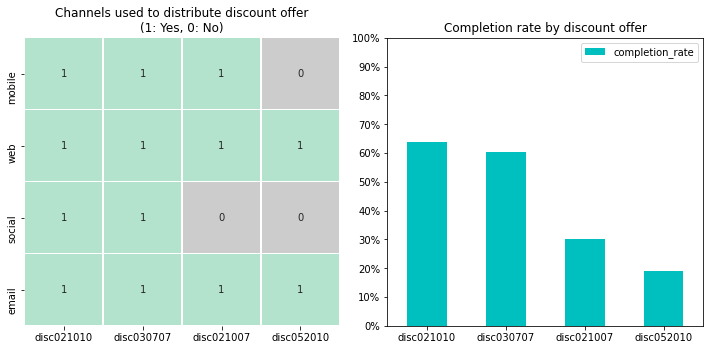

In [145]:
# Subset discount offers
completion_by_discounts = completion_by_offer.iloc[completion_by_offer.index.str.contains('disc')].reset_index()
channels = ['mobile', 'web', 'social', 'email']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Figure1 - heatmap for binary
discounts_by_offer = completion_by_discounts.set_index('offer_name')[channels]
sns.heatmap(discounts_by_offer.T, linewidths = 0.30, annot = True, 
            cmap='Pastel2_r', cbar=False, ax=ax1);

# Labels
ax1.set_title('Channels used to distribute discount offer\n(1: Yes, 0: No)')
ax1.set(xlabel='', ylabel='')

# Figure2 - bar
completion_by_discounts[['offer_name', 'completion_rate']].plot(kind='bar', ax=ax2, color='coolrwarm')

# Labels
ax2.set(title='Completion rate by discount offer')
ax2.set_xticks(ticks=np.arange(len(completion_by_discounts)))
ax2.set_xticklabels(labels=completion_by_discounts['offer_name'], rotation=0)
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

plt.tight_layout(pad=1.2)

# Save figure
plt.savefig('images/channels_by_discount.png')
plt.show()

For discounts offer, the completion rate is over 50% for `disc021010`, `disc030707`. It looks that looking wide distribution channels including **social** and **mobile** is crucial to ensure higher completion rate of the offer type.   


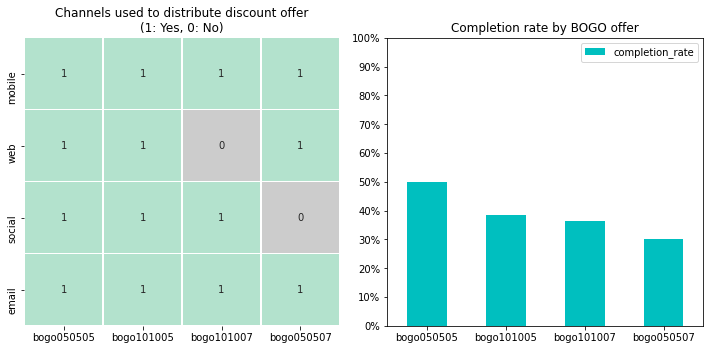

In [12]:
# Subset bogos offers
completion_by_bogos = completion_by_offer.iloc[completion_by_offer.index.str.contains('bogo')].reset_index()
channels = ['mobile', 'web', 'social', 'email']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Figure1 - heatmap for binary
bogos_by_offer = completion_by_bogos.set_index('offer_name')[channels]
sns.heatmap(bogos_by_offer.T, linewidths = 0.30, annot = True, 
            cmap='Pastel2_r', cbar=False, ax=ax1);

# Labels
ax1.set_title('Channels used to distribute discount offer\n(1: Yes, 0: No)')
ax1.set(xlabel='', ylabel='')

# Figure2 - bar
completion_by_bogos[['offer_name', 'completion_rate']].plot(kind='bar', ax=ax2, color='coolrwarm')

# Labels
ax2.set(title='Completion rate by BOGO offer')
ax2.set_xticks(ticks=np.arange(len(completion_by_bogos)))
ax2.set_xticklabels(labels=completion_by_bogos['offer_name'], rotation=0)
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

plt.tight_layout(pad=1.2)

# Save figure
plt.savefig('images/channels_by_bogo.png')
plt.show()

Only `bogo050505` has a completion rate as high as 50% whereas the other three were not relatively preferred. 

The same finding is true for BOGO offers that a wide use of channels is important for completion rate. Along with channel, it is also adviasble to set the difficulty of redemption lower. Given the comparison between `bogo050505` and `bogo101005`, `bogo050505` is higher in the completion rate with lower difficulty despite lower rewards given out.

In [147]:
# Saving the dataframe in case of any future use
completion_by_offer.to_csv('data/completion_by_offer.csv', index=True)

## 4c. Offer completion by demographics

### Prepare dataset

In [15]:
# Load the clean dataset
profile_v1 = pd.read_csv('data/profile_v1.csv', parse_dates=True)
transcript_labeled = pd.read_csv('data/transcript_labeled.csv')
del transcript_labeled['Unnamed: 0']


# Create a function to prepare dataset for analysis
def prepare_completion_by_demo(df1=transcript_labeled, df2=profile_v1):
    ''' Function to prepare a dataframe ready for the analysis
    of offer completion by demographics.
    
    INPUT (set by default): 
        df1: the transcript_labeled dataset 
        df2: the cleaned profile_v1 dataset
        
    OUTPUT: a new merged dataframe 
    '''
    
    # Get all records that were sent (excluding unsent)
    offer_sent = df1[df1['offer_status'] != 'unsent']
    
    # Merge with profile_v1 dataset
    completion_by_demo = pd.merge(offer_sent, df2, 
                                  left_on='person', right_on='id', how='left')

    # Drop the duplicated id column
    completion_by_demo = completion_by_demo.drop(columns='id')

    
    return completion_by_demo

In [16]:
completion_by_demo = prepare_completion_by_demo()
completion_by_demo.head()

,person,offer_id,offer received,offer viewed,offer completed,offer_status,amount,reward,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,completed,NaN,NaN,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,completed,NaN,NaN,M,33.0,2017-04-21,72000.0
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,6.0,NaN,completed,NaN,NaN,O,40.0,2018-01-09,57000.0
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336.0,354.0,NaN,completed,NaN,NaN,O,40.0,2018-01-09,57000.0
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,504.0,660.0,NaN,completed,NaN,NaN,F,59.0,2016-03-04,90000.0


In [150]:
# Saving the dataframe in case of any future use
completion_by_demo.to_csv('data/completion_by_demo.csv', index=True)

### Completion by gender

The below heatmap visualization was inspired by https://moonbooks.org/Articles/How-to-add-text-units--etc-in-a-heatmap-cell-annotations-using-seaborn-in-python-/

In [17]:
completion_by_demo

,person,offer_id,offer received,offer viewed,offer completed,offer_status,amount,reward,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,completed,NaN,NaN,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,completed,NaN,NaN,M,33.0,2017-04-21,72000.0
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,6.0,NaN,completed,NaN,NaN,O,40.0,2018-01-09,57000.0
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336.0,354.0,NaN,completed,NaN,NaN,O,40.0,2018-01-09,57000.0
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,504.0,660.0,NaN,completed,NaN,NaN,F,59.0,2016-03-04,90000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,0.0,6.0,36.0,completed,6.97,5.0,M,34.0,2017-01-23,34000.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168.0,174.0,198.0,completed,22.88,5.0,F,45.0,2016-11-25,62000.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336.0,354.0,384.0,completed,15.57,2.0,F,45.0,2016-11-25,62000.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,534.0,504.0,incomplete,7.79,5.0,F,45.0,2016-11-25,62000.0


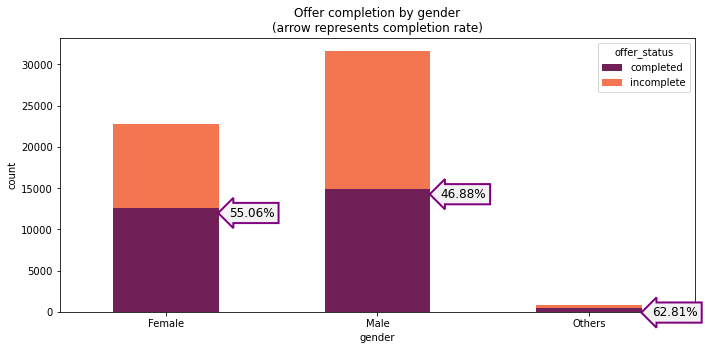

In [19]:
# Set color for plot
rocket_color = sns.color_palette('rocket')
fig_color = [rocket_color[1], rocket_color[-2]]

# Pivot completion by gender
completion_by_gender = completion_by_demo.groupby(['offer_status', 'gender']).size().unstack()

# Plot 
completion_by_gender.T.plot(kind='bar', stacked=True, color=fig_color, figsize=(10,5));

# Annotation
for i, val in enumerate(completion_by_gender.columns):
    compl = completion_by_gender[val][0]    
    incomplete = completion_by_gender[val][1]    
    total = completion_by_gender[val].sum()
    bbox_props = dict(boxstyle="larrow", fc=(0.95, 0.95, 0.95), ec='purple', lw=2)
    plt.text(i+0.3, compl-1000, '{:.2f}%'.format(compl / total * 100), 
             color='#000', bbox=bbox_props, fontsize=12)

plt.title('Offer completion by gender\n(arrow represents completion rate)')
plt.xticks(rotation=0, ticks=np.arange(3), labels=['Female', 'Male', 'Others'])
plt.ylabel('count')

# Save figure
plt.tight_layout(pad=1.2)
plt.savefig('images/completion_by_gender.png')

plt.show()

Female customers generally have higher completion rate than male. Male customers have less offers completed than incomplete.

### Completion by age

In [20]:
# Divide each record with age group
bin_edges = np.arange(10, 100+10, 10)
bin_label = [str(n)+ 's' for n in bin_edges[:-1]]
completion_by_demo['age_group'] = pd.cut(completion_by_demo.age, bins=bin_edges, labels=bin_label)

# Pivot completion by age
completion_by_age = completion_by_demo.groupby(['offer_status', 'age_group']).size().unstack()

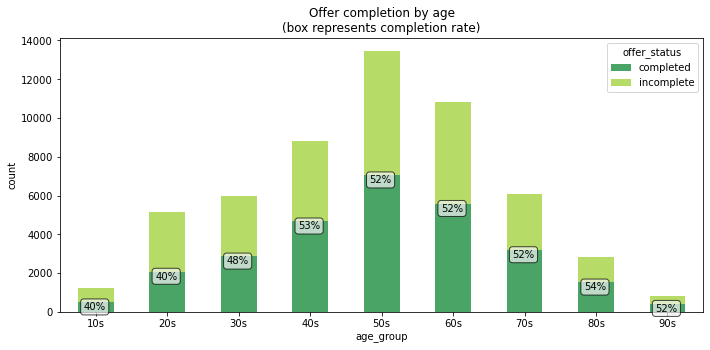

In [25]:
summer_color = sns.color_palette('summer')
fig_color2 = [summer_color[1], summer_color[-2]]

# Plot 
completion_by_age.T.plot(kind='bar', stacked=True, color=fig_color2, figsize=(10,5));

# Annotation
for i, val in enumerate(completion_by_age.columns):
    compl = completion_by_age[val][0]    
    incomplete = completion_by_age[val][1]    
    total = completion_by_age[val].sum()
    bbox_props = dict(boxstyle='round', facecolor=(0.95, 0.95, 0.95), alpha=0.7)
    plt.text(i-.17, compl-400, '{:.0f}%'.format(compl / total * 100), 
             color='#030303', fontsize=10, bbox=bbox_props)

plt.title('Offer completion by age\n(box represents completion rate)')
plt.xticks(rotation=0)
plt.ylabel('count')

# Save figure
plt.tight_layout(pad=1.2)
plt.savefig('images/completion_by_age.png')

plt.show()

Completion rate is low (lower than incomplete) for customers below 30s whereas those above 40s have completion rate higher than 50%.

### Completion by income

In [22]:
# Divide each record with income group
bin_edges = np.arange(completion_by_demo.income.min(), 
                       completion_by_demo.income.max() + 10000, 10000)
bin_label = ['$' + str(int(n))[:-3] + 'k' for n in bin_edges[:-1]]
completion_by_demo['income_group'] = pd.cut(completion_by_demo.income, bins=bin_edges, labels=bin_label)


# Pivot completion by income
completion_by_income = completion_by_demo.groupby(['offer_status', 'income_group']).size().unstack()

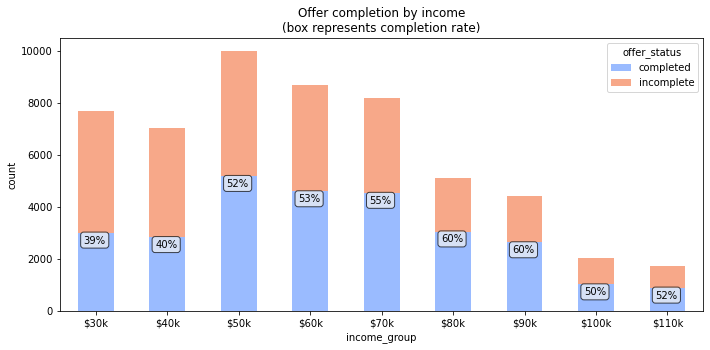

In [24]:
coolwarm_color = sns.color_palette('coolwarm')
fig_color3 = [coolwarm_color[1], coolwarm_color[-2]]

# Plot 
completion_by_income.T.plot(kind='bar', stacked=True, color=fig_color3, figsize=(10,5));

# Annotation
for i, val in enumerate(completion_by_income.columns):
    compl = completion_by_income[val][0]    
    incomplete = completion_by_income[val][0]    
    total = completion_by_income[val].sum()
    bbox_props = dict(boxstyle='round', facecolor=(0.95, 0.95, 0.95), alpha=0.7)
    plt.text(i-.17, compl-400, '{:.0f}%'.format(compl / total * 100), 
             color='#030303', fontsize=10, bbox=bbox_props)

plt.title('Offer completion by income\n(box represents completion rate)')
plt.xticks(rotation=0)
plt.ylabel('count')

# Save figure
plt.tight_layout(pad=1.2)
plt.savefig('images/completion_by_income.png')

plt.show()

Completion rate is lower for customers with income less than \\$50k. The higest completion rate is observed in the income group between \\$80k and \\$100k.

---
<a id="feature"></a>
## `SECTION5` Feature engineering
Now merge the cleaned dataset to prepare for a classifer model.

In [349]:
# Load dataset
portfolio_cleaned = pd.read_csv('data/portfolio_v1.csv')
profile_cleaned = pd.read_csv('data/profile_v1.csv')
transcript_labeled = pd.read_csv('data/transcript_labeled.csv')

del transcript_labeled['Unnamed: 0']

## 5a. Merging the dataset - 1
the cleaned transcript and profile

In [350]:
df_merged_first = pd.merge(transcript_labeled, profile_cleaned, left_on='person', right_on='id', how='left')
df_merged_first.head()

,person,offer_id,offer received,offer viewed,offer completed,offer_status,amount,reward,gender,age,id,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,completed,NaN,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,completed,NaN,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0
2,00116118485d4dfda04fdbaba9a87b5c,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,unsent,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00116118485d4dfda04fdbaba9a87b5c,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,unsent,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,6.0,NaN,completed,NaN,NaN,O,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0


In [351]:
df_merged_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169940 entries, 0 to 169939
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            169940 non-null  object 
 1   offer_id          169940 non-null  object 
 2   offer received    63288 non-null   float64
 3   offer viewed      49135 non-null   float64
 4   offer completed   28996 non-null   float64
 5   offer_status      169940 non-null  object 
 6   amount            28996 non-null   float64
 7   reward            28996 non-null   float64
 8   gender            148200 non-null  object 
 9   age               148200 non-null  float64
 10  id                148200 non-null  object 
 11  became_member_on  148200 non-null  object 
 12  income            148200 non-null  float64
dtypes: float64(7), object(6)
memory usage: 18.2+ MB


#### Commentary:

There are null values in gender, age, became_member_on and income columns that are resulted from the removed records for `profile_clean` (those missing gender and income data with age of 118), which can be dropped agin. 

Also, there are columns that are not informational, which need to be dropped
- id column,
- offer received, offer viewed and offer completed

Lastly, there are many missing values in amount, reward columns indicating no transactions completed. We will the values with 0.

### Drop unnecessary columns

In [352]:
drop_cols = ['id', 'offer received', 'offer viewed', 'offer completed']
df_merged_first.drop(columns=drop_cols, inplace=True)

### Handling missing values

In [353]:
# Fill amount, reward columns with 0
df_merged_first[['amount', 'reward']] = df_merged_first[['amount', 'reward']].apply(lambda x: x.fillna(0))

In [354]:
# Drop entries with no gender, age and income values
df_merged_first.dropna(inplace=True)

In [355]:
# change for null values
assert df_merged_first.isnull().sum().sum() == 0, "There still is a missing value"

## 5b. Merging the dataset - 2
df_merged_first and portfolio

In [356]:
df_merged = pd.merge(df_merged_first, portfolio_cleaned, left_on='offer_id', right_on='id', how='left')
df_merged.head()

,person,offer_id,offer_status,amount,reward_x,gender,age,became_member_on,income,reward_y,difficulty,duration,offer_type,id,mobile,social,email,web
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,completed,0.0,0.0,M,33.0,2017-04-21,72000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,completed,0.0,0.0,M,33.0,2017-04-21,72000.0,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,completed,0.0,0.0,O,40.0,2018-01-09,57000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,completed,0.0,0.0,O,40.0,2018-01-09,57000.0,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
4,0020c2b971eb4e9188eac86d93036a77,3f207df678b143eea3cee63160fa8bed,unsent,0.0,0.0,F,59.0,2016-03-04,90000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1


In [357]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148200 entries, 0 to 148199
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            148200 non-null  object 
 1   offer_id          148200 non-null  object 
 2   offer_status      148200 non-null  object 
 3   amount            148200 non-null  float64
 4   reward_x          148200 non-null  float64
 5   gender            148200 non-null  object 
 6   age               148200 non-null  float64
 7   became_member_on  148200 non-null  object 
 8   income            148200 non-null  float64
 9   reward_y          148200 non-null  int64  
 10  difficulty        148200 non-null  int64  
 11  duration          148200 non-null  int64  
 12  offer_type        148200 non-null  object 
 13  id                148200 non-null  object 
 14  mobile            148200 non-null  int64  
 15  social            148200 non-null  int64  
 16  email             14

In [358]:
# There shouldn't be any missing values
assert df_merged.isnull().sum().sum() == 0, "There is a missing value in the dataframe"

#### Commentary:
- There is no null values.  
- Drop the duplicated columns: `reward` and `id`

### Drop duplicated columns

In [359]:
df_merged.drop(columns=['reward_x', 'id'], inplace=True)
df_merged.rename(columns={'reward_y':'reward'}, inplace=True)

In [360]:
# Store the merged dataframe 
df_merged.to_csv('data/starbucks_merged.csv', index=False)

### 5c. Feature engineering

We are going to make a model that predicts if offer will be completed or incomplete. 
Also, we will see if there is any possibility of offer completion for those offers unsent. 

In order to do that, we will train a classifier model with the subset dataset from `df_merged` where `offer_status` is either completed or incomplete - so **unsent** label will be set aside. In addition, non-numeric features which needs some encoding and features should be standardized to ensure similar sacling applied.  

#### Here is a list of preprocessing needed:

**target variable** : `offer_status`
- Create the subset dataframe excluding **unsent** offer status
- Then **offer_status** will be transformed into binary values (1: completed, 2: incomplete)


**features**
- drop **person** column
- drop **offer_id**: **offer_id** & **offer_type** somehow deliver similar information 
- convert **gender** & **offer_type** features into dummy variables 
- destructure **became_member_on** into joined_year and joined_month columns (int) 

### Reload the merged dataset

In [361]:
# Reload the merged dataset
df_merged = pd.read_csv('data/starbucks_merged.csv')
df_merged.head()

,person,offer_id,offer_status,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,mobile,social,email,web
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,completed,0.0,M,33.0,2017-04-21,72000.0,0,0,4,informational,1,0,1,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,completed,0.0,M,33.0,2017-04-21,72000.0,0,0,3,informational,1,1,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,completed,0.0,O,40.0,2018-01-09,57000.0,0,0,4,informational,1,0,1,1
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,completed,0.0,O,40.0,2018-01-09,57000.0,0,0,3,informational,1,1,1,0
4,0020c2b971eb4e9188eac86d93036a77,3f207df678b143eea3cee63160fa8bed,unsent,0.0,F,59.0,2016-03-04,90000.0,0,0,4,informational,1,0,1,1


### Functions for feature engineering

In [362]:
def get_dummies(df, cols):
    ''' Convert categorical variables into dummary variables
    
    INPUT: 
        df: a dataframe that contains a column of categorical data  
        cols: the columns that need conversion
    OUTPUT: a converted dataframe in binary values
    '''
    
    return pd.get_dummies(df[cols], dtype=int)


def destucture_date(df, col, fmt='%Y-%m-%d'):
    ''' Convert a date column into date object 
    following the input format, and destructure it into
    year, month and day
    
    INPUT:
        df: a dataframe that contains a column of date information  
        col: the column with data values
        fmt: default as %Y-%m-%d, date format of the input col
    
    OUTPUT: a series of year, month and day
    '''
    
    # Trnasform the input column into datetime object 
    date_obj = pd.to_datetime(df[col], format=fmt)

    # Destucture date_obj into a series of year, month and day
    year = date_obj.dt.year
    month = date_obj.dt.month
    day = date_obj.dt.day
    
    
    return year, month, day
    
    
def seperate_offers(df=df_merged):
    ''' Divide the merged dataframe into offer_sent and offer_unsent
    subset dataframes. 
    
    INPUT: the 'df_merged' dataframe
    OUTPUT: two dataframes 
        offer_sent: a dataframe that contains offers that have been sent
            which will be used for training
        offer_unsent: a dataframe that contains unsent offers
            which will be set aside for any later use.
    
    '''
    # Get the subset of offers sent and unsent
    offer_sent = df.query('offer_status != "unsent"')
    offer_unsent = df.query('offer_status == "unsent"')
    
    return offer_sent, offer_unsent


def prepare_features(df):
    ''' 
    and return a target variable and features ready for classification
    as well as a dataframe that contains unsent offer data
    
    INPUT: a dataframe that is ready for feature engineering
    OUTPUT: a target variable, a set of features and a dataframe with unsent
    offer data
    
    '''

    #### Now we perform feature engineering on the input dataframe 
        
    # Get target variable: 'offer_status' & features
    target = df['offer_status'].map({'completed':1, 'incomplete':0, 'unsent': 0})
    
    # Get features by dropping 'offer_status' (target variable )
    # Also drop unnessary 'person' and 'offer_id' features
    features = df.drop(columns=['offer_status', 'person', 'offer_id'])
    
    # Convert gender and offer_type into dummy variables
    # then join into the features 
    # then drop 'gender', 'offer_type' columns
    dummies = get_dummies(features, ['gender', 'offer_type'])
    features = features.join(dummies).drop(columns=['gender', 'offer_type'])

    # Destructure became_member_on column into year, month and day
    # then add series of year and month into features (exclude day: too granular)
    # then drop 'became_member_on' column
    year, month, day  = destucture_date(features, 'became_member_on')
    features['joined_year'] = year
    features['joined_month'] = month
    
    features = features.drop(columns='became_member_on')
    
    
    return features, target
    

In [363]:
# Divide the merge dataset into offers sent and unsent
offer_sent, offer_unsent = seperate_offers(df_merged)

# Get variables for training from offer_sent
features, target = prepare_features(offer_sent)

In [364]:
# Confirm the result
assert target.nunique() == 2
assert len(target) == df_merged.query('offer_status!="unsent"').shape[0]
assert len(features) == df_merged.query('offer_status!="unsent"').shape[0]
assert offer_unsent.offer_status.unique() == 'unsent'
print('Feature engineering has been completed!')

Feature engineering has been completed!


In [365]:
# all features are now numeric with no missing values
features.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 148199
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   amount                    55222 non-null  float64
 1   age                       55222 non-null  float64
 2   income                    55222 non-null  float64
 3   reward                    55222 non-null  int64  
 4   difficulty                55222 non-null  int64  
 5   duration                  55222 non-null  int64  
 6   mobile                    55222 non-null  int64  
 7   social                    55222 non-null  int64  
 8   email                     55222 non-null  int64  
 9   web                       55222 non-null  int64  
 10  gender_F                  55222 non-null  int64  
 11  gender_M                  55222 non-null  int64  
 12  gender_O                  55222 non-null  int64  
 13  offer_type_bogo           55222 non-null  int64  
 14  offer

<a id="model"></a>
# `SECTION6` Modeling

We would like to build a classifier model to predict a customer with a particular offer type will make a purchase of a product influenced by the offer (complete the offer). 

We have two classes either **completed** or **incomplete** in our target varaible `offer_status` and would like to have the number of these two classes balanced (similar). This will give a good reference when choosing the split method for training and test sets. If the target variable is balanced, we will be able to use random split, otherwise we may need to consider using alternative method such as stratified split.

To illustrate, let's take an example of a dataset of 1000 records where the target variable is not balanced (say class A has 900 and class B has 100 records). If random splitting is adopted withotu considering the balance, we may end up having train set with a majority of class A labels and the model will be biased. So we wouldl like to avoid this by checking **invariant metric** as below.

### 5a. Get variables ready for training

In [366]:
# Divide the merge dataset into offers sent and unsent
offer_sent, offer_unsent = seperate_offers(df_merged)

# Get variables for training from offer_sent
features, target = prepare_features(offer_sent)

### 5b. Splitting into training and test set

In [367]:
# Check invariant metric for the target variable

def check_invariant_metric(series, alpha=0.05):
    ''' Run simulations to see if the target variable has balanced 
    by testing the number of each class group is similar.
    
    Calculated p-value will be compared to the alpha value to see
    if there is statistical sigificance enough the reject the null.
    
    The higher p-value, it is harder to reject the null which then
    means target variable is balanced and good to go.
    
    Return True if successful False if not.

    INPUT: 
        series: a Pandas series of target variable
        alpha: level of significance that the calculated p-value
            will be compared to for the final decision, default at 0.05

    OUTPUT: boolean
    
    '''
    
    # Set parameters under null
    n_obs = target.shape[0]
    p = 0.5
    n_trials = 20000
    
    samples = np.random.binomial(n_obs, p, n_trials)
    
    # Get actual count - the number of 1(completed)
    n_control = target.value_counts().values[0] 
    

    # Calculate p-value for the 2-sided test
    p_value = np.logical_or(samples <= n_control, 
                            samples >= (n_obs - n_control)).mean()
       
    # Decision rule: 
    if p_value < alpha:
        # Reject the null: target variable is not balanced
        return False
    else:
        # Fail to reject the null: target variable is balanced
        return True
    

In [368]:
def split_train_test_sets(X, y):
    ''' Split data into train and test sets
    if target variable is balanced, continue with random split
    or return None with error message
    
    INPUT:
        X: features 
        y: taret variable
        
    OUTPUT:
        X_train, X_test, y_train, y_test
        or None (when the dataset is not balanced)
        
    '''
    
    # True if the target variable is balanced
    if check_invariant_metric(y):
        return train_test_split(X, y)

    else:
        print('The dataset is not balanced',
              'check for alternative split method')
        return None

In [369]:
# Random split the dataset - splitting should work
X_train, X_test, y_train, y_test = split_train_test_sets(features, target)

### 5c. Train logistic regression model (`model1`)

In [370]:
# Fitting the model
model01 = LogisticRegression(random_state=42, max_iter=10000)
model01.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [371]:
def clf_predict(model, X_test):
    ''' Run predictions for a fitted classifer model
    
    INPUT:
        model: a fitted classifer model
        X_test: test features used for prediction
        
    OUTPUT:
        y_pred: the predicted target variable
        
    '''
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    return y_pred
    

def print_classification_scores(y_test, y_pred):
    ''' Show test scores for classification as one go
    by combining accuracy score and classification report.
    
    INPUT: 
        model: the classifier model that fit training sets
        y_test: a true y test values
        y_pred: a predicted y values
        
    OUTPUT:
        None
        
    '''
       
    # Get test scores
    print(f'Accuracy score: {accuracy_score(y_test, y_pred) * 100:.2f}%')
    print(f'Classfication report:\n')
    print(classification_report(y_test, y_pred))
    

In [372]:
# Make predictions
y_pred01 = clf_predict(model01, X_test)

In [373]:
print_classification_scores(y_test, y_pred01)

Accuracy score: 73.98%
Classfication report:

              precision    recall  f1-score   support

           0       0.76      0.69      0.73      6896
           1       0.72      0.79      0.75      6910

    accuracy                           0.74     13806
   macro avg       0.74      0.74      0.74     13806
weighted avg       0.74      0.74      0.74     13806



Not extremely bad score for all metrics for the first model. Let's see see if standardization can improve the result in the pipeline, and then fit a model with different parameters by using GridSearch. 

In [374]:
# Build pipeline including 
pipeline01 = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf01', LogisticRegression())
])

# Set different parameters for grid search
params01 = {
    'clf01__C': [0.1, 0.5, 1.0],
    'clf01__solver': ('lbfgs', 'sag')
}

# Build a pipeline with grid search
model01_search = GridSearchCV(pipeline01, params01, verbose=1)

# Fit the model
model01_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s finished


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf01', LogisticRegression())]),
             param_grid={'clf01__C': [0.1, 0.5, 1.0],
                         'clf01__solver': ('lbfgs', 'sag')},
             verbose=1)

In [375]:
# Make prediction
y_pred01_search = clf_predict(model01_search.best_estimator_, X_test)

# Print classification scores
print_classification_scores(y_test, y_pred01_search)

Accuracy score: 77.18%
Classfication report:

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      6896
           1       0.76      0.80      0.78      6910

    accuracy                           0.77     13806
   macro avg       0.77      0.77      0.77     13806
weighted avg       0.77      0.77      0.77     13806



Accuracy score went up by 3% with the best parameters searched. f1-score also improved!
Let's see if the model can produce better result with other classifier methods like decision trees or random forest.

In [90]:
# Save to file in the models folder
with open("models/logreg.pkl", 'wb') as file:
    pickle.dump(model01_search.best_estimator_, file)

### 5d. Train Decision Tree classifier (`model2`)

In [376]:
# Fitting the model
model02 = DecisionTreeClassifier()
model02.fit(X_train, y_train)

DecisionTreeClassifier()

In [377]:
# Make predictions
y_pred02 = clf_predict(model02, X_test)

In [378]:
# Print scores
print_classification_scores(y_test, y_pred02)

Accuracy score: 76.95%
Classfication report:

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6896
           1       0.78      0.76      0.77      6910

    accuracy                           0.77     13806
   macro avg       0.77      0.77      0.77     13806
weighted avg       0.77      0.77      0.77     13806



Without any parameter seeting accuracy score and f1-score scores are close the best estimater of Logistic Regerssion. Let's do parameter setting and se if it can improve the result.

In [379]:
# Build pipeline including 
pipeline02 = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf02', DecisionTreeClassifier())
])

# Set different parameters for grid search
params02 = {
    'clf02__criterion': ('gini', 'entropy'),
    'clf02__min_samples_split': [2, 10, 20, 50, 100],
    'clf02__min_samples_leaf': [1, 5, 10, 20, 50, 100]
}

# Build a pipeline with grid search
model02_search = GridSearchCV(pipeline02, params02, verbose=3)

# Fit the model
model02_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2, score=0.770, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2, score=0.770, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2, score=0.760, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2, score=0.773, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=2, score=0.764, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10, score=0.772, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10, score=0.771, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10, score=0.766, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=1, clf02__min_samples_split=10 
[CV]  clf02__criterion=

[CV]  clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100, score=0.827, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100, score=0.818, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100, score=0.818, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100, score=0.827, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=5, clf02__min_samples_split=100, score=0.812, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=10, clf02__min_samples_split=2 
[CV]  clf02

[CV]  clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=20, score=0.819, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=20 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=20, score=0.805, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50, score=0.819, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50, score=0.816, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50, score=0.809, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=20, clf02__min_samples_split=50 
[CV]  clf0

[CV]  clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10, score=0.831, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10, score=0.832, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10, score=0.824, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10, score=0.833, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10 
[CV]  clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=10, score=0.819, total=   0.1s
[CV] clf02__criterion=gini, clf02__min_samples_leaf=100, clf02__min_samples_split=20 


[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=1, clf02__min_samples_split=100, score=0.816, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=1, clf02__min_samples_split=100 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=1, clf02__min_samples_split=100, score=0.827, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=1, clf02__min_samples_split=100 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=1, clf02__min_samples_split=100, score=0.815, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=5, clf02__min_samples_split=2 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=5, clf02__min_samples_split=2, score=0.781, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=5, clf02__min_samples_split=2 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=5, clf02__min_samples_split=2, score=0.777, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=5, clf02__min_samples

[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=20, score=0.790, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50, score=0.816, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50, score=0.807, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50, score=0.808, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__min_samples_split=50, score=0.818, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=10, clf02__mi

[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10, score=0.829, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10, score=0.827, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10, score=0.822, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10, score=0.830, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__min_samples_split=10, score=0.818, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=50, clf02__mi

[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100, score=0.831, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100, score=0.826, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100, score=0.833, total=   0.1s
[CV] clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100 
[CV]  clf02__criterion=entropy, clf02__min_samples_leaf=100, clf02__min_samples_split=100, score=0.819, total=   0.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   32.3s finished


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf02', DecisionTreeClassifier())]),
             param_grid={'clf02__criterion': ('gini', 'entropy'),
                         'clf02__min_samples_leaf': [1, 5, 10, 20, 50, 100],
                         'clf02__min_samples_split': [2, 10, 20, 50, 100]},
             verbose=3)

In [380]:
# Make predictions
print(model02_search.best_estimator_)
y_pred02_search = clf_predict(model02_search.best_estimator_, X_test)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf02',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_leaf=100))])


In [382]:
# Print scores
print_classification_scores(y_test, y_pred02_search)

Accuracy score: 82.72%
Classfication report:

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      6896
           1       0.79      0.89      0.84      6910

    accuracy                           0.83     13806
   macro avg       0.83      0.83      0.83     13806
weighted avg       0.83      0.83      0.83     13806



Now the test score a lot more improved. After running grid search several times, it looks that the test score gets better with higher `min_samples_split` (**try change to verbose=3 in GridSearchCV**). So let's test it with `min_samples_split` parameter only.

In [383]:
# Build pipeline including 
pipeline02b = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf02', DecisionTreeClassifier())
])

# Set different parameters for grid search
params02b = {
    'clf02__min_samples_leaf': np.arange(0,1000+100,100)[1:]
}

# Build a pipeline with grid search
model02_search_b = GridSearchCV(pipeline02b, params02b, verbose=3)

# Fit the model
model02_search_b.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clf02__min_samples_leaf=100 .....................................
[CV] ......... clf02__min_samples_leaf=100, score=0.831, total=   0.1s
[CV] clf02__min_samples_leaf=100 .....................................
[CV] ......... clf02__min_samples_leaf=100, score=0.832, total=   0.1s
[CV] clf02__min_samples_leaf=100 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ......... clf02__min_samples_leaf=100, score=0.824, total=   0.1s
[CV] clf02__min_samples_leaf=100 .....................................
[CV] ......... clf02__min_samples_leaf=100, score=0.833, total=   0.1s
[CV] clf02__min_samples_leaf=100 .....................................
[CV] ......... clf02__min_samples_leaf=100, score=0.819, total=   0.1s
[CV] clf02__min_samples_leaf=200 .....................................
[CV] ......... clf02__min_samples_leaf=200, score=0.829, total=   0.1s
[CV] clf02__min_samples_leaf=200 .....................................
[CV] ......... clf02__min_samples_leaf=200, score=0.832, total=   0.1s
[CV] clf02__min_samples_leaf=200 .....................................
[CV] ......... clf02__min_samples_leaf=200, score=0.826, total=   0.1s
[CV] clf02__min_samples_leaf=200 .....................................
[CV] ......... clf02__min_samples_leaf=200, score=0.832, total=   0.1s
[CV] clf02__min_samples_leaf=200 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.4s finished


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf02', DecisionTreeClassifier())]),
             param_grid={'clf02__min_samples_leaf': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             verbose=3)

In [384]:
model02_search_b.best_estimator_ 

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf02', DecisionTreeClassifier(min_samples_leaf=200))])

In [385]:
# Make predictions
y_pred02_search_b = clf_predict(model02_search_b.best_estimator_, X_test)

# Print scores
print_classification_scores(y_test, y_pred02_search_b)

Accuracy score: 83.09%
Classfication report:

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      6896
           1       0.79      0.90      0.84      6910

    accuracy                           0.83     13806
   macro avg       0.84      0.83      0.83     13806
weighted avg       0.84      0.83      0.83     13806



Best estimator turned to be with the parameter of `min_samples_leaf=200` produces a similar result as the one set at `in_samples_leaf=100.`

In [109]:
# Save the first dtree model (min_samples_leaf=100)
with open("models/dtree.pkl", 'wb') as file:
    pickle.dump(model02_search.best_estimator_, file)

# Save the second dtree model (min_samples_leaf=200)
with open("models/dtree_b.pkl", 'wb') as file:
    pickle.dump(model02_search_b.best_estimator_, file)

### 5e. Train Suppor Vector Machine classifier (`model3`)

After a trial, it was found that SVC is extremely slow as it trains with non-linear kernel (stack overflow reference [here](https://stackoverflow.com/questions/40077432/why-is-scikit-learn-svm-svc-extremely-slow)). So let's try with LinearSVC where no kernels are used.

In [386]:
# Fitting the model
model03 = LinearSVC(max_iter=10000) # fit linear svc first
model03.fit(X_train, y_train)

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=10000)

max_iter set to 10000 as the default threw a convergence error.

In [387]:
# Make predictions
y_pred03 = clf_predict(model03, X_test)

# Print scores
print_classification_scores(y_test, y_pred03)

Accuracy score: 61.34%
Classfication report:

              precision    recall  f1-score   support

           0       0.85      0.28      0.42      6896
           1       0.57      0.95      0.71      6910

    accuracy                           0.61     13806
   macro avg       0.71      0.61      0.56     13806
weighted avg       0.71      0.61      0.56     13806



Hmm...the model using Linear SVC did not improve the test result. Assuming that it is because SVM is sensitive to different scaling, let's try to build a pipeline using standard scaler [Stack overflow reference](https://stackoverflow.com/questions/39001936/techniques-to-improve-the-accuracy-of-svm-classifier).

In [388]:
# Build pipeline including 
pipeline03 = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf03', LinearSVC(max_iter=10000))
])

# Fit the data to pipeline03
pipeline03.fit(X_train, y_train)

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf03', LinearSVC(max_iter=10000))])

In [389]:
# Make predictions
y_pred03b = clf_predict(pipeline03, X_test)

# Print scores
print_classification_scores(y_test, y_pred03b)

Accuracy score: 70.89%
Classfication report:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      6896
           1       0.71      0.71      0.71      6910

    accuracy                           0.71     13806
   macro avg       0.71      0.71      0.71     13806
weighted avg       0.71      0.71      0.71     13806



The model is improved with scaler but as much as the previous ones using other classifiers. Let's see if parameter setting can improve the model better.

In [43]:
# Build pipeline including 
pipeline03 = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf03', LinearSVC(max_iter=10000))
])

# Set different parameters for grid search
params03 = {
    'clf03__C': [0.1, 0.5, 1.0],
    'clf03__max_iter': [5000, 10000, 20000],
}

# Build a pipeline with grid search
model03_search = GridSearchCV(pipeline03, params03, verbose=3, cv=3)

# Fit the model (takes ~ 30mins) 
# model03_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] clf03__C=0.1, clf03__max_iter=5000 ..............................
[CV] ............... clf03__C=0.1, clf03__max_iter=5000, total=  12.3s
[CV] clf03__C=0.1, clf03__max_iter=5000 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV] ............... clf03__C=0.1, clf03__max_iter=5000, total=  12.6s
[CV] clf03__C=0.1, clf03__max_iter=5000 ..............................
[CV] ............... clf03__C=0.1, clf03__max_iter=5000, total=   9.9s
[CV] clf03__C=0.1, clf03__max_iter=5000 ..............................
[CV] ............... clf03__C=0.1, clf03__max_iter=5000, total=  11.6s
[CV] clf03__C=0.1, clf03__max_iter=5000 ..............................
[CV] ............... clf03__C=0.1, clf03__max_iter=5000, total=  11.8s
[CV] clf03__C=0.1, clf03__max_iter=10000 .............................
[CV] .............. clf03__C=0.1, clf03__max_iter=10000, total=  11.0s
[CV] clf03__C=0.1, clf03__max_iter=10000 .............................
[CV] .............. clf03__C=0.1, clf03__max_iter=10000, total=  11.9s
[CV] clf03__C=0.1, clf03__max_iter=10000 .............................
[CV] .............. clf03__C=0.1, clf03__max_iter=10000, total=   9.7s
[CV] clf03__C=0.1, clf03__max_iter=10000 .............................
[CV] .

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=0.5, clf03__max_iter=5000, total=  23.5s
[CV] clf03__C=0.5, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=0.5, clf03__max_iter=5000, total=  23.3s
[CV] clf03__C=0.5, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=0.5, clf03__max_iter=5000, total=  23.5s
[CV] clf03__C=0.5, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=0.5, clf03__max_iter=5000, total=  23.9s
[CV] clf03__C=0.5, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=0.5, clf03__max_iter=5000, total=  23.7s
[CV] clf03__C=0.5, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=0.5, clf03__max_iter=10000, total=  47.1s
[CV] clf03__C=0.5, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=0.5, clf03__max_iter=10000, total=  47.3s
[CV] clf03__C=0.5, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=0.5, clf03__max_iter=10000, total=  49.3s
[CV] clf03__C=0.5, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=0.5, clf03__max_iter=10000, total=  51.4s
[CV] clf03__C=0.5, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=0.5, clf03__max_iter=10000, total=  47.1s
[CV] clf03__C=0.5, clf03__max_iter=20000 .............................
[CV] .............. clf03__C=0.5, clf03__max_iter=20000, total= 1.0min
[CV] clf03__C=0.5, clf03__max_iter=20000 .............................
[CV] .............. clf03__C=0.5, clf03__max_iter=20000, total= 1.1min
[CV] clf03__C=0.5, clf03__max_iter=20000 .............................
[CV] .............. clf03__C=0.5, clf03__max_iter=20000, total=  51.2s
[CV] clf03__C=0.5, clf03__max_iter=20000 .............................
[CV] .............. clf03__C=0.5, clf03__max_iter=20000, total= 1.1min
[CV] clf03__C=0.5, clf03__max_iter=20000 .............................
[CV] .............. clf03__C=0.5, clf03__max_iter=20000, total= 1.1min
[CV] clf03__C=1.0, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=1.0, clf03__max_iter=5000, total=  23.6s
[CV] clf03__C=1.0, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=1.0, clf03__max_iter=5000, total=  24.1s
[CV] clf03__C=1.0, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=1.0, clf03__max_iter=5000, total=  23.4s
[CV] clf03__C=1.0, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=1.0, clf03__max_iter=5000, total=  23.4s
[CV] clf03__C=1.0, clf03__max_iter=5000 ..............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............... clf03__C=1.0, clf03__max_iter=5000, total=  23.4s
[CV] clf03__C=1.0, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=10000, total=  47.0s
[CV] clf03__C=1.0, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=10000, total=  46.9s
[CV] clf03__C=1.0, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=10000, total=  46.7s
[CV] clf03__C=1.0, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=10000, total=  47.1s
[CV] clf03__C=1.0, clf03__max_iter=10000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=10000, total=  47.0s
[CV] clf03__C=1.0, clf03__max_iter=20000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=20000, total= 1.5min
[CV] clf03__C=1.0, clf03__max_iter=20000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=20000, total= 1.6min
[CV] clf03__C=1.0, clf03__max_iter=20000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=20000, total= 1.7min
[CV] clf03__C=1.0, clf03__max_iter=20000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] .............. clf03__C=1.0, clf03__max_iter=20000, total= 1.7min
[CV] clf03__C=1.0, clf03__max_iter=20000 .............................


/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 28.2min finished


[CV] .............. clf03__C=1.0, clf03__max_iter=20000, total= 1.7min


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf03', LinearSVC(max_iter=10000))]),
             param_grid={'clf03__C': [0.1, 0.5, 1.0],
                         'clf03__max_iter': [5000, 10000, 20000]},
             verbose=2)

In [45]:
# Make predictions
y_pred03c = clf_predict(model03_search.best_estimator_, X_test)

# Print scores
print_classification_scores(y_test, y_pred03c)

Accuracy score: 71.86%
Classfication report:

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      6811
           1       0.72      0.72      0.72      6995

    accuracy                           0.72     13806
   macro avg       0.72      0.72      0.72     13806
weighted avg       0.72      0.72      0.72     13806



In [51]:
# Save to file in the models folder
with open("models/clf_linearsvc.pkl", 'wb') as file:
    pickle.dump(model03_search.best_estimator_, file)

Despite the computationally expensive, the model with LinearSVC did not produce satisficatory result. Let's fit the final model with RandomForest classifier given that the best classfier used decision tree up to this point and random forest is a collection of decision trees.

### 5f. Train Random Forest classifier (`model4`)

In [100]:
# Fitting the model
model04 = RandomForestClassifier(n_estimators=100) # default
model04.fit(X_train, y_train)

RandomForestClassifier()

In [101]:
# Make predictions
y_pred04 = clf_predict(model04, X_test)

# Print scores
print_classification_scores(y_test, y_pred04)

Accuracy score: 82.35%
Classfication report:

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      6819
           1       0.80      0.88      0.83      6987

    accuracy                           0.82     13806
   macro avg       0.83      0.82      0.82     13806
weighted avg       0.83      0.82      0.82     13806



The random forest classifier resulted in better results than the default decision tree without any parameter setting, which is promising. Let's now find the best parameters using random forest with Grid Search in the pipeline with standardizer.

In [102]:
# Build pipeline including 
pipeline04 = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf04', RandomForestClassifier())
])

# Set different parameters for grid search
params04 = {
    'clf04__n_estimators': [100,200,500],
    'clf04__min_samples_split': [2, 10, 20, 50, 100],
    'clf04__min_samples_leaf': [1, 5, 10, 20, 50, 100] 
}

# Build a pipeline with grid search
model04_search = GridSearchCV(pipeline04, params04, verbose=3)

# Fit the model
model04_search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.822, total=   2.4s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.822, total=   2.3s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.816, total=   2.3s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.818, total=   2.4s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.818, total=   2.4s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=200, score=0.822, total=   4.8s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=200, score=0.822, total=   4.8s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=2, clf04__n_estimators=200 
[CV]  clf0

[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=20, clf04__n_estimators=500, score=0.826, total=   9.7s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100, score=0.830, total=   1.8s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100, score=0.830, total=   1.8s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100, score=0.832, total=   1.8s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100, score=0.830, total=   1.8s
[CV] clf04__min_samples_leaf=1, clf04__min_samples_split=50, clf04__n_estimators=100 


[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500, score=0.829, total=   9.5s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500, score=0.827, total=   9.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500, score=0.829, total=   9.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500, score=0.829, total=   9.5s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=2, clf04__n_estimators=500, score=0.825, total=   9.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=10, clf04__n_estimators=100 
[CV]  clf

[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=200, score=0.832, total=   3.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=200, score=0.831, total=   3.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=200, score=0.825, total=   3.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=500, score=0.832, total=   8.3s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=500, score=0.830, total=   8.4s
[CV] clf04__min_samples_leaf=5, clf04__min_samples_split=50, clf04__n_estimators=500 


[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=100, score=0.830, total=   1.7s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=100, score=0.825, total=   1.8s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=200, score=0.830, total=   3.5s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=200, score=0.830, total=   3.5s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estimators=200, score=0.830, total=   3.5s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=10, clf04__n_estima

[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=50, clf04__n_estimators=500, score=0.826, total=   8.2s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100, score=0.831, total=   1.6s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100, score=0.828, total=   1.6s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100, score=0.833, total=   1.6s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04__n_estimators=100, score=0.831, total=   1.6s
[CV] clf04__min_samples_leaf=10, clf04__min_samples_split=100, clf04_

[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500, score=0.831, total=   7.8s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500, score=0.828, total=   7.9s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500, score=0.832, total=   7.8s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500, score=0.830, total=   7.9s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=10, clf04__n_estimators=500, score=0.824, total=   7.8s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=20, clf04__n_estima

[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200, score=0.828, total=   3.0s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200, score=0.832, total=   3.0s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200, score=0.829, total=   3.0s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=200, score=0.825, total=   3.0s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04__n_estimators=500, score=0.832, total=   7.4s
[CV] clf04__min_samples_leaf=20, clf04__min_samples_split=100, clf04

[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=100, score=0.830, total=   1.4s
[CV] clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=100, score=0.827, total=   1.4s
[CV] clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=100, score=0.823, total=   1.4s
[CV] clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=200, score=0.830, total=   2.8s
[CV] clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=200 
[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estimators=200, score=0.828, total=   2.8s
[CV] clf04__min_samples_leaf=50, clf04__min_samples_split=20, clf04__n_estima

[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=100, clf04__n_estimators=500, score=0.827, total=   7.0s
[CV] clf04__min_samples_leaf=50, clf04__min_samples_split=100, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=50, clf04__min_samples_split=100, clf04__n_estimators=500, score=0.823, total=   6.9s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.831, total=   1.3s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.827, total=   1.3s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_estimators=100 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_estimators=100, score=0.829, total=   1.4s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=2, clf04__n_est

[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=200, score=0.823, total=   2.6s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500, score=0.832, total=   6.5s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500, score=0.827, total=   6.5s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500, score=0.829, total=   6.6s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500 
[CV]  clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04__n_estimators=500, score=0.825, total=   6.5s
[CV] clf04__min_samples_leaf=100, clf04__min_samples_split=20, clf04

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 32.2min finished


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf04', RandomForestClassifier())]),
             param_grid={'clf04__min_samples_leaf': [1, 5, 10, 20, 50, 100],
                         'clf04__min_samples_split': [2, 10, 20, 50, 100],
                         'clf04__n_estimators': [100, 200, 500]},
             verbose=3)

In [103]:
# Make predictions
y_pred04 = clf_predict(model04_search.best_estimator_, X_test)

# Print scores
print_classification_scores(y_test, y_pred04)

Accuracy score: 83.20%
Classfication report:

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      6819
           1       0.80      0.90      0.84      6987

    accuracy                           0.83     13806
   macro avg       0.84      0.83      0.83     13806
weighted avg       0.84      0.83      0.83     13806



This classifier model using random forest performed just as good as the earlier decision tree.

In [104]:
# Save to file in the models folder
with open("models/clf_randomforest.pkl", 'wb') as file:
    pickle.dump(model04_search.best_estimator_, file)

<a id="work"></a>
[to modules](#modules)

---
<a id="conclude"></a>
# `SECTION 6` Conclusion

To this point, we have performed exploratory analysis on individual and merged datasets and conducted machine learning to build a classifier model. We would like to find how customers have interacted with differnt offers and finally to predict if offers would be completed or not when particular offers were sent to customers with different characteristics.

Furthermore, we have identified a matrix of 169,940 possible interactions between customers an offer types from 16,994 unique customers and 10 different offers (refer to `transcript_labled` data). 63% of them are labeled unsent possibly because the previous business decisions identified that some offers would not match customers with certain characterstics, resources(time, costs, etc.) were limited or just by chance.

Therefore, in this conclusion section, we would also like to apply our classifier model to those offers unsent and find opportunities for any future promotional activites.

### Recap on offers

Offers were grouped into three categories: bogo, discount and informational. bogo and discount are transactional following the below funnel and offers are considered completion if customers reponsed to all :

    offer received -> offer viewed -> purchased -> offer completed
        
In the meantime, informational offers are considered compelted when customers received and viewed offers (as they do not lead to transactions).
    

### Insights gained from the exploatory analysis:
<br>
<b>About offers</b>

- Amongst the three offer categories, discount offers are the most difficult to redeem (on average 11.75) but have the longest duration allowing customers to be influenced the most.

- The two informational offers named as `info000003` and `info000004` recorded high completion rate above 60%. Especially, 'info000003' had the extremrely high completion rate (around 90%) despite a slightly shorter duration than the other. It was found that this different may come from communication channels: other than email and mobile, 'info000003' distributed on social media as opposed web that 'info000004' used.

- There are two transactional offers marked above 60% completion rate and they both fall into discount category. Although these two offers are more difficult to redeem (with less rewards given), they have higher duration and wider distribution across all existing channels so customers were exposed and influenced more.

**Note**: the offer name follows the convention using the first 4 letters of'offer_type', 2 digits of respective 'reward', 'difficulty', 'duration'.

<br>
<b>About demographics</b>

- Of those offers sent, 47% were copmleted indicating that customers viewed offers and made purchases (bogo / disount) or were made aware of offers (informational).

- Female customers have higher completion rate than male customers (53% vs 45%).

- Offer completion rate is lower than 50% for age groups below 50.

- Income groups bewteen 80k and 100k have the highest completion rate (60%). It marked at least 40% completion rate across all income groups.





### Finally, handling unsent offers 
Let's apply our classifier model to those offers unsent. This will give good references for any future promotional activities.

Get the subset detaframe for unsent offers (`offer_unsent`) using `seperate_offers` function and run feature engineering with `prepare_features` function.

We load a classifier built with decision tree as it performed the best (also computationally cheaper than the random forecast classifier resulting the similar performance.)

In [135]:
# Returning offer_unsent dataframe again
_, offer_unsent = seperate_offers(df_merged)

# Run feature engineering 
unsent_X, unsent_y = prepare_features(offer_unsent)

`unsent_X` should contain features ready for prediction. All values for `unsent_y` should be 0 (incomplete).

In [136]:
assert offer_unsent.offer_status.unique() == 'unsent'
assert unsent_y.sum() == 0
print('Successfully loaded offer_unsent dataframe')

Successfully loaded offer_unsent dataframe


In [111]:
# Load a classifier from pickle
with open("models/dtree.pkl", 'rb') as file:
    classifier = pickle.load(file)

In [140]:
# 15.9% of unsent offers predicted to be completed
classifier.predict(X).mean()

0.15905913226784832

#### Commentary:
About 15.9% of unsent offers expected to be completed. However, remember that the accuracy of the decision tree is 84% so it seems that these 16% may just be resulted from the misclassification error from the model.

Due to this limitation, it is not yet certain if we need to take any actions (i.e. send offers again) on those unsent offers classified `completed or 1`.

Instead, it may be more relevant to use this classifier model on new dataset (with new customers and offers with the same features as the dataset used for modeling) and run tests like A/B test to compare completion rate or any other key business indicator.

<a id="bottom"></a>
#### This is the end of this notebook. Click [here](#top) to move up to the beginning.